# Choosing Lens Galaxies from CosmoDC2 galaxies in the DDF Region

Author: Bryce Kalmbach ([@jbkalmbach](https://github.com/jbkalmbach))

Last Updated: 4/30/20

In this notebook we are choosing galaxies that are present in the CosmoDC2 catalog of the DDF region to be lens galaxies as we sprinkle in strongly lensed systems. The choice of which galaxies to use will require matching DDF galaxies to lens galaxies in the systems from the [Oguri and Marshall 2010 catalog](https://github.com/drphilmarshall/OM10) (for strongly lensed AGN) and the [Goldstein et al 2019 catalog](https://arxiv.org/abs/1809.10147) (for strongly lensed SNe). 

We then perform a second matching to get the host galaxies for the systems chosen to be added into the DDF. The host galaxies from the lensing catalogs are matched to cosmoDC2 galaxies from well outside the DDF and the properties of the lens systems are then recalculated to get correct time delays and image properties.

In [2]:
import sys
sys.path.append('../../../sprinkler/')
import os
import GCRCatalogs
import pandas as pd
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
from astropy.io import fits
from sqlalchemy import create_engine
from GCR import GCRQuery

from astropy.cosmology import FlatLambdaCDM
import sncosmo

from lsst.sims.catUtils.dust.EBV import EBVbase
from lens_catalog_readers import OM10Reader, GoldsteinSNeCatReader

from lsst.sims.photUtils import Sed, BandpassDict, getImsimFluxNorm, Bandpass
from lsst.utils import getPackageDir
from copy import deepcopy

# %load_ext autoreload
# %autoreload 2

## Load CosmoDC2 Data in DDF region with GCR

Our first step is to load in all the cosmoDC2 galaxies from the DDF with `GCRCatalogs`

In [2]:
catalog_version = 'cosmoDC2_v1.1.4'

In [ ]:
catalog = GCRCatalogs.load_catalog(str(catalog_version + '_image_addon_knots'))

In [ ]:
quantity_list = ['galaxy_id',
                 'ra',
                 'dec',
                 'redshift_true',
                 'shear_1',
                 'shear_2_phosim',
                 'convergence',
                 'position_angle_true',
                 'size_true',
                 'size_minor_true',
                 'size_disk_true',
                 'size_minor_disk_true',
                 'size_bulge_true',
                 'size_minor_bulge_true',
                 'ellipticity_true',
                 'sersic_disk',
                 'sersic_bulge',
                 'stellar_mass_disk',
                 'stellar_mass_bulge',
                 'stellar_mass',
                 'totalStarFormationRate',
                 'morphology/spheroidHalfLightRadius', 
                 'morphology/spheroidHalfLightRadiusArcsec',
                 'mag_true_r_lsst',
                 'mag_true_i_lsst'
                ]

We first pick a set of potential lens galaxies within the DDF. Here we just grab all the galaxies from the DDF. In subsequent steps we will narrow this down to galaxies that are large elliptical galaxies. We are going to relate these to the lens catalogs using the velocity dispersion and redshift to match to similar systems.

In [5]:
dc2_all_lens_gals = catalog.get_quantities(quantity_list, filters=['ra < 53.755', 'ra > 52.495',
                                                                      'dec < -27.55', 'dec > -28.65'])

In [7]:
### To save:
# with open('%s/ddf_all_lens_gals.pkl' % os.environ['SCRATCH'], 'wb') as f:
#     pickle.dump(dc2_all_lens_gals, f)
    
### To load:
# with open('%s/ddf_all_lens_gals.pkl' % os.environ['SCRATCH'], 'rb') as f:
#     dc2_all_lens_gals = pickle.load(f)

We also pick a set of potential host galaxies from the opposite corner of the CosmoDC2 field from the DDF. We are going to use these galaxies to match to the lensing systems and use some of their properties when we add in lensed host galaxies to the DDF.

In [8]:
dc2_all_host_gals = catalog.get_quantities(quantity_list, filters=['ra < 75.', 'ra > 72.5',
                                                                            'dec < -42.5', 'dec > -45.',
                                                                            'redshift_true > 0.25'])

In [3]:
### To save:
# with open('%s/ddf_all_host_gals.pkl' % os.environ['SCRATCH'], 'wb') as f:
#     pickle.dump(dc2_all_host_gals, f)
    
## To load:
# with open('%s/ddf_all_host_gals.pkl' % os.environ['SCRATCH'], 'rb') as f:
#     dc2_all_host_gals = pickle.load(f)

## Match Host galaxies to AGN-hosting CosmoDC2 galaxies from outside the DDF

For the host galaxies we want to add in the AGN properties to those that host AGN since we want lensed AGN and lensed SNe. To do this we load the AGN database and match on `galaxy_id`.

In [4]:
import sqlite3

In [5]:
agn_db_file = '/global/cscratch1/sd/jchiang8/desc/sims_GCRCatSimInterface/work/2020-02-14/agn_cosmoDC2_v1.1.4.db'

In [6]:
conn = sqlite3.connect(agn_db_file)
cur = conn.cursor()

In [7]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('agn_params',)]


In [8]:
agn_df = pd.read_sql_query("SELECT * from agn_params", conn)

In [9]:
agn_df.head()

,galaxy_id,htmid_8,magNorm,redshift,M_i,ra,dec,varParamStr
0,1250000080,147070,24.532759,0.045305,-12.570935,50.823681,-27.152892,"{""m"": ""applyAgn"", ""p"": {""seed"": 4353780, ""agn_..."
1,1250001927,147054,24.977323,0.088624,-13.584557,51.722197,-25.667408,"{""m"": ""applyAgn"", ""p"": {""seed"": 9678465, ""agn_..."
2,1250004840,147060,24.596580,0.115142,-14.631356,49.778938,-25.982403,"{""m"": ""applyAgn"", ""p"": {""seed"": 7595204, ""agn_..."
3,1250005239,147047,23.916831,0.113542,-15.264852,50.901542,-25.769011,"{""m"": ""applyAgn"", ""p"": {""seed"": 7102854, ""agn_..."
4,1250009839,145048,23.638732,0.146706,-16.036147,50.356496,-25.032873,"{""m"": ""applyAgn"", ""p"": {""seed"": 3578619, ""agn_..."


In [10]:
len(agn_df)

4221027

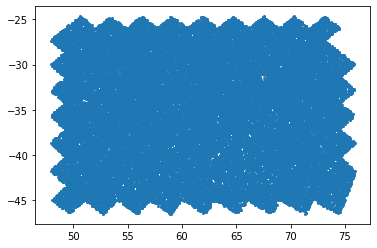

In [11]:
plt.scatter(agn_df['ra'][::100], agn_df['dec'][::100], s=4)

In [12]:
agn_df_cut = agn_df.query('ra > 72.5 and ra < 75. and dec > -45 and dec < -42.5 and redshift > 0.25')

Check how many AGN the region we've selected will give us as potential lensed hosts.

In [13]:
len(agn_df_cut)

43086

43k should be enough. We want to end up with ~1000 in our DDF sample.

We also need to grab the AGN in the DDF to make sure that none of our lens galaxies has an AGN.

In [14]:
agn_in_ddf = agn_df.query('ra < 53.755 and ra > 52.495 and dec < -27.55 and dec > -28.65')

### Get healpix ids

We will need these to open the correct SED files.

In [15]:
import healpy
def get_healpix_id(ra, dec):
    pix_id = healpy.ang2pix(32, ra, dec, nest=False, lonlat=True)
    return pix_id

In [22]:
len(dc2_all_lens_gals['ra'])

6194586

In [23]:
healpix_ids_lenses = get_healpix_id(dc2_all_lens_gals['ra'], dc2_all_lens_gals['dec'])

In [24]:
healpix_ids_lenses

array([8914, 8914, 8914, ..., 9043, 9043, 9043])

In [16]:
healpix_ids_hosts = get_healpix_id(dc2_all_host_gals['ra'], 
                                   dc2_all_host_gals['dec'])

In [17]:
healpix_ids_hosts

array([10201, 10201, 10201, ..., 10452, 10452, 10452])

### Put galaxy information into pandas dataframe

In [27]:
lens_gal_df = pd.DataFrame(dc2_all_lens_gals)

In [28]:
lens_gal_df.head()

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,morphology/spheroidHalfLightRadiusArcsec,position_angle_true,ra,convergence,mag_true_i_lsst,size_disk_true,size_minor_disk_true,stellar_mass,size_minor_true,ellipticity_true
0,19.664267,1.074651,1.0,7396574.0,0.692787,-0.000000,2.623878e+06,0.020617,0.654324,5.135591e+06,...,0.692787,3.872094,52.545849,0.000000,19.426846,1.390374,0.733156,1.253216e+07,0.742982,0.182473
1,19.639227,1.433365,1.0,1097576.5,0.739462,-0.000000,4.610795e+06,0.019394,0.674218,6.849424e+06,...,0.739462,151.776670,52.623324,0.000000,19.457127,1.494187,0.670891,7.947000e+06,0.685062,0.353235
2,21.385635,2.377272,1.0,0.0,0.913097,-0.000000,1.059278e+04,0.017482,0.896222,1.003473e+06,...,0.913097,50.902277,52.681314,0.000000,21.097429,2.377272,0.970572,1.003473e+06,0.970572,0.420181
3,18.350533,3.245566,1.0,9869368.0,1.537620,-0.000000,1.586908e+07,0.017347,1.532605,3.920008e+07,...,1.537620,174.550510,52.581461,0.000000,18.165789,3.411983,3.347761,4.906946e+07,3.188943,0.008800
4,21.644880,1.405769,1.0,1162219.0,0.602592,-0.000023,5.564104e+06,0.046867,0.566917,7.509686e+06,...,0.602592,117.095584,52.737179,-0.000014,21.411554,1.470491,1.000541,8.671905e+06,0.980436,0.178246


In [29]:
lens_gal_df['healpix_id'] = healpix_ids_lenses

In [18]:
host_gal_df = pd.DataFrame(dc2_all_host_gals)

In [19]:
host_gal_df.head()

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,morphology/spheroidHalfLightRadiusArcsec,position_angle_true,ra,convergence,mag_true_i_lsst,size_disk_true,size_minor_disk_true,stellar_mass,size_minor_true,ellipticity_true
0,19.147808,1.443660,1.0,1.510516e+10,1.012711,0.000458,6.447332e+09,0.25686,0.916337,2.338286e+10,...,1.012711,28.787977,72.607130,-0.002380,18.781584,1.545864,1.293610,3.848801e+10,1.226328,0.081398
1,23.047113,0.271755,1.0,0.000000e+00,0.153582,0.000587,2.385710e+08,0.25686,0.152041,2.003216e+08,...,0.153582,135.359014,72.613209,-0.002250,22.770948,0.271755,0.223761,2.003216e+08,0.223761,0.096857
2,22.363756,0.567076,1.0,0.000000e+00,0.261468,0.000457,1.324979e+05,0.25686,0.254134,4.675741e+08,...,0.261468,179.613169,72.597708,-0.002471,22.094297,0.567076,0.393428,4.675741e+08,0.393428,0.180789
3,25.148592,0.167496,1.0,0.000000e+00,0.084224,0.000568,1.169752e+07,0.25686,0.083505,1.600792e+07,...,0.084224,109.102593,72.608670,-0.002250,24.886253,0.167496,0.115785,1.600792e+07,0.115785,0.182542
4,22.020205,0.652051,1.0,0.000000e+00,0.316920,0.000519,3.441400e+08,0.25686,0.315717,7.094749e+08,...,0.316920,145.525863,72.596165,-0.002246,21.715946,0.652051,0.637959,7.094749e+08,0.637959,0.010924


In [20]:
host_gal_df['healpix_id'] = healpix_ids_hosts

In [21]:
np.unique(healpix_ids_hosts, return_counts=True)

(array([10201, 10202, 10328, 10329, 10452, 10572]),
 array([  794648,   978249,    42432, 13804046,  7343597,       19]))

To make SED loading quicker (we have to load an entire healpixel worth of SED info at a time as we will show below) we will only take the four healpixels with the most galaxies.

In [22]:
host_gal_df = host_gal_df.query('healpix_id < 10203 or healpix_id == 10329 or healpix_id == 10452').reset_index(drop=True)

### Join host bulge/disk and agn databases on `galaxy_id`

In [23]:
host_gal_full = host_gal_df.join(agn_df.set_index('galaxy_id'), on='galaxy_id', rsuffix='_agn')

In [24]:
host_gal_full = host_gal_full.rename(columns={'magNorm':'magNorm_agn', 
                                              'varParamStr':'varParamStr_agn',
                                              'redshift':'redshift_agn'})

In [25]:
agn_host_gal_full = host_gal_full.query('ra_agn > -99.').reset_index(drop=True)

In [26]:
agn_host_gal_full.head(2)

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,size_minor_true,ellipticity_true,healpix_id,htmid_8,magNorm_agn,redshift_agn,M_i,ra_agn,dec_agn,varParamStr_agn
0,19.558434,1.755462,1.0,5.390875e+10,1.589502,0.001386,1.845465e+07,0.303496,1.522582,7.155991e+09,...,1.685611,0.020299,10201,144291.0,23.752536,0.303496,-17.790545,72.57645,-42.536578,"{""m"": ""applyAgn"", ""p"": {""seed"": 6324137, ""agn_..."
1,19.813519,1.282438,1.0,1.940904e+10,0.868923,0.001669,1.002159e+09,0.303507,0.753715,8.473058e+09,...,0.910856,0.169417,10201,144291.0,24.761045,0.303507,-16.782145,72.57532,-42.533373,"{""m"": ""applyAgn"", ""p"": {""seed"": 7181317, ""agn_..."


In [27]:
len(agn_host_gal_full)

43010

Good, we still have ~43000 systems even after dropping 2 healpixels.

In [28]:
sne_host_gal_full = host_gal_full.iloc[np.where(np.isnan(host_gal_full['M_i'].values))]

In [29]:
len(sne_host_gal_full)

22877530

We don't really need this many. We just want a sample big enough to match to ~1000 host galaxies from the Goldstein et al. catalog. Let's only keep 1/100 to speed things up.

In [30]:
sne_host_gal_full = sne_host_gal_full.iloc[::100]

In [31]:
len(sne_host_gal_full)

228776

In [32]:
sne_host_gal_full = sne_host_gal_full.reset_index(drop=True)

In [33]:
sne_host_gal_full.head()

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,size_minor_true,ellipticity_true,healpix_id,htmid_8,magNorm_agn,redshift_agn,M_i,ra_agn,dec_agn,varParamStr_agn
0,19.147808,1.443660,1.0,1.510516e+10,1.012711,0.000458,6.447332e+09,0.256860,0.916337,2.338286e+10,...,1.226328,0.081398,10201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26.182716,0.222752,1.0,0.000000e+00,0.094638,0.002202,2.963854e+04,0.250130,0.092058,2.300287e+06,...,0.176510,0.115817,10201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25.285751,0.206980,1.0,2.646877e+06,0.103148,0.003750,9.319455e+06,0.250320,0.099730,9.339962e+06,...,0.140048,0.192871,10201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24.756550,0.247567,1.0,2.805823e+06,0.119716,0.000723,1.566986e+07,0.250225,0.117719,1.493341e+07,...,0.223525,0.051035,10201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25.898499,0.204694,1.0,0.000000e+00,0.091120,0.002367,5.139789e+04,0.251596,0.080544,3.180387e+06,...,0.040981,0.666382,10201,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate i-band mags for AGN

In [35]:
lsst_bp_dict = BandpassDict.loadTotalBandpassesFromFiles()

In [36]:
os.listdir(os.path.join(getPackageDir('SIMS_SED_LIBRARY'), 'agnSED'))

['agn.spec.gz']

In [37]:
agn_sed = Sed()
agn_sed.readSED_flambda(os.path.join(getPackageDir('SIMS_SED_LIBRARY'), 'agnSED', 'agn.spec.gz'))

In [38]:
mag_i_agn = []
for agn_data in agn_host_gal_full[['magNorm_agn', 'redshift_true']].values:
    agn_mag, agn_redshift = agn_data
    if np.isnan(agn_mag):
        mag_i_agn.append(np.nan)
        continue
    agn_copy = deepcopy(agn_sed)
    flux_norm = getImsimFluxNorm(agn_copy, agn_mag)
    agn_copy.multiplyFluxNorm(flux_norm)
    agn_copy.redshiftSED(agn_redshift, dimming=True)
    mag_i_agn.append(agn_copy.calcMag(lsst_bp_dict['i']))

In [39]:
agn_host_gal_full['mag_i_agn'] = mag_i_agn

In [40]:
agn_host_gal_full.head(10)

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,ellipticity_true,healpix_id,htmid_8,magNorm_agn,redshift_agn,M_i,ra_agn,dec_agn,varParamStr_agn,mag_i_agn
0,19.558434,1.755462,1.0,5.390875e+10,1.589502,0.001386,1.845465e+07,0.303496,1.522582,7.155991e+09,...,0.020299,10201,144291.0,23.752536,0.303496,-17.790545,72.576450,-42.536578,"{""m"": ""applyAgn"", ""p"": {""seed"": 6324137, ""agn_...",23.577279
1,19.813519,1.282438,1.0,1.940904e+10,0.868923,0.001669,1.002159e+09,0.303507,0.753715,8.473058e+09,...,0.169417,10201,144291.0,24.761045,0.303507,-16.782145,72.575320,-42.533373,"{""m"": ""applyAgn"", ""p"": {""seed"": 7181317, ""agn_...",24.585786
2,19.778311,0.847371,1.0,7.096259e+10,0.804792,0.000858,2.941172e+07,0.348136,0.765873,9.416485e+09,...,0.039129,10201,144288.0,24.726687,0.348136,-17.071811,72.589333,-43.114100,"{""m"": ""applyAgn"", ""p"": {""seed"": 2221308, ""agn_...",24.558383
3,20.780214,0.377860,1.0,7.515603e+09,0.295911,0.001518,4.933921e+08,0.364838,0.268692,4.269180e+09,...,0.134161,10201,144291.0,26.666270,0.364838,-15.265509,72.571873,-42.702451,"{""m"": ""applyAgn"", ""p"": {""seed"": 5286209, ""agn_...",26.500103
4,21.270239,0.823948,1.0,2.806170e+10,0.822198,0.004328,1.834959e+04,0.446487,0.572032,3.956686e+07,...,0.180092,10201,144291.0,25.008189,0.446487,-17.341452,72.854422,-42.511687,"{""m"": ""applyAgn"", ""p"": {""seed"": 7166592, ""agn_...",24.790650
5,21.920746,0.363422,1.0,1.106134e+10,0.317425,0.004183,4.975796e+08,0.467317,0.278152,3.738243e+08,...,0.115059,10201,144288.0,26.563393,0.467317,-15.869930,72.744129,-42.926226,"{""m"": ""applyAgn"", ""p"": {""seed"": 8584799, ""agn_...",26.338894
6,21.403263,0.330368,1.0,1.140627e+10,0.295592,0.004628,2.383782e+08,0.463055,0.272661,9.480793e+08,...,0.058278,10201,144288.0,27.327995,0.463055,-15.053496,72.563920,-42.880291,"{""m"": ""applyAgn"", ""p"": {""seed"": 1275907, ""agn_...",27.104330
7,20.983217,0.417677,1.0,1.440132e+10,0.336431,0.002901,4.331877e+09,0.520946,0.210630,2.680969e+10,...,0.463972,10201,144291.0,26.813883,0.520946,-15.881948,72.584951,-42.589501,"{""m"": ""applyAgn"", ""p"": {""seed"": 4156022, ""agn_...",26.578994
8,20.767252,0.824154,1.0,1.062921e+11,0.819994,0.000937,1.657991e+05,0.533874,0.666118,1.622201e+09,...,0.106545,10201,144288.0,24.684347,0.533874,-18.068410,72.627155,-42.985973,"{""m"": ""applyAgn"", ""p"": {""seed"": 5243173, ""agn_...",24.443504
9,21.200270,0.726081,1.0,7.454884e+10,0.726081,0.004335,3.041201e+08,0.552012,0.518302,2.695974e+01,...,0.166973,10329,144291.0,24.508712,0.552012,-18.309940,72.882689,-42.545015,"{""m"": ""applyAgn"", ""p"": {""seed"": 307545, ""agn_s...",24.267363


## Load cached SED information for galaxies

We need to load in SEDs for each galaxy. These have been previously assigned and cached but are stored by healpix id.

In [41]:
sed_dir = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup'

In [42]:
import h5py

In [55]:
sed_df = pd.DataFrame([], columns=['bulge_av',
 'bulge_rv',
 'bulge_sed',
 'disk_av',
 'disk_rv',
 'disk_sed',
 'galaxy_id',])

In [56]:
for hpix in np.unique(healpix_ids_lenses):
    f = h5py.File(os.path.join(sed_dir, 'sed_fit_%i.h5' % hpix))
    
    sed_hpix_df = pd.DataFrame([])

    band_list = ['u', 'g', 'r', 'i', 'z', 'y']
    sed_names = f['sed_names'][()]
    for key in list(f.keys()):
        print(key, f[key].len())
        # if (key.endswith('fluxes') or key.endswith('magnorm')):
        if key.endswith('magnorm'):
            key_data = f[key][()]
            for i in range(6):
                sed_hpix_df[str(key + '_' + band_list[i])] = key_data[i]
        elif key in ['sed_names', 'ra', 'dec']:
            continue
        elif key.endswith('fluxes'):
            continue
        elif key.endswith('sed'):
            sed_hpix_df[key] = [sed_names[idx] for idx in f[key][()]]
        else:
            sed_hpix_df[key] = f[key][()]
            
    sed_df = pd.concat([sed_df, sed_hpix_df], sort=False)

bulge_av 17251417
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17251417
bulge_sed 17251417
dec 17251417
disk_av 17251417
disk_fluxes 6
disk_magnorm 6
disk_rv 17251417
disk_sed 17251417
galaxy_id 17251417
ra 17251417
redshift 17251417
sed_names 959
tot_fluxes 6
bulge_av 17215541
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17215541
bulge_sed 17215541
dec 17215541
disk_av 17215541
disk_fluxes 6
disk_magnorm 6
disk_rv 17215541
disk_sed 17215541
galaxy_id 17215541
ra 17215541
redshift 17215541
sed_names 959
tot_fluxes 6
bulge_av 17182059
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17182059
bulge_sed 17182059
dec 17182059
disk_av 17182059
disk_fluxes 6
disk_magnorm 6
disk_rv 17182059
disk_sed 17182059
galaxy_id 17182059
ra 17182059
redshift 17182059
sed_names 959
tot_fluxes 6


In [57]:
sed_df = sed_df.reset_index(drop=True)

In [58]:
sed_df.tail()

,bulge_av,bulge_rv,bulge_sed,disk_av,disk_rv,disk_sed,galaxy_id,bulge_magnorm_u,bulge_magnorm_g,bulge_magnorm_r,bulge_magnorm_i,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift
51649012,0.1,2.0,b'galaxySED/Inst.16E08.1Z.spec.gz',0.1,2.8,b'galaxySED/Inst.10E08.04Z.spec.gz',2583392369,31.630559,30.313428,30.157882,30.176097,30.135977,30.093492,30.664487,30.274829,30.126130,30.117537,30.114116,30.077079,2.998998
51649013,0.1,2.0,b'galaxySED/Inst.20E08.02Z.spec.gz',0.1,2.2,b'galaxySED/Inst.80E07.02Z.spec.gz',2583392370,32.589788,31.523507,31.372035,31.325759,31.233770,31.232998,34.161275,33.793000,33.617714,33.588306,33.563978,33.531616,3.027994
51649014,0.1,2.0,b'galaxySED/Burst.12E09.04Z.spec.gz',0.0,2.0,b'galaxySED/Burst.12E09.04Z.spec.gz',2583392371,31.515505,30.968997,30.666512,30.682875,30.631993,30.628849,32.077059,31.735684,31.496479,31.634260,31.697040,31.595417,2.998962
51649015,0.1,2.0,b'galaxySED/Inst.20E08.04Z.spec.gz',0.0,2.0,b'galaxySED/Inst.16E08.02Z.spec.gz',2583392372,32.624034,31.205463,31.060750,31.030399,30.935369,30.914757,33.214225,32.782739,32.621995,32.589319,32.579632,32.500410,2.986596
51649016,0.0,2.0,b'galaxySED/Burst.16E08.02Z.spec.gz',0.1,2.4,b'galaxySED/Inst.20E08.04Z.spec.gz',2583392373,inf,inf,inf,inf,inf,inf,30.855779,29.909156,29.748025,29.702780,29.619985,29.583251,3.001044


In [59]:
len(sed_df)

51649017

## Join databases on `galaxy_id`

In [60]:
full_lens_join = lens_gal_df.join(sed_df.set_index('galaxy_id'), on='galaxy_id')

In [61]:
full_lens_join.head()

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,bulge_magnorm_i,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift
0,19.664267,1.074651,1.0,7396574.0,0.692787,-0.000000,2.623878e+06,0.020617,0.654324,5.135591e+06,...,21.026474,21.033885,21.024401,20.431332,20.477106,20.462002,20.450845,20.477642,20.471547,0.020709
1,19.639227,1.433365,1.0,1097576.5,0.739462,-0.000000,4.610795e+06,0.019394,0.674218,6.849424e+06,...,22.752948,22.771718,22.789151,19.823513,19.883602,19.890613,19.898893,19.941111,19.948358,0.019261
2,21.385635,2.377272,1.0,0.0,0.913097,-0.000000,1.059278e+04,0.017482,0.896222,1.003473e+06,...,inf,inf,inf,21.668665,21.815566,21.863569,21.881901,21.916558,21.933702,0.017699
3,18.350533,3.245566,1.0,9869368.0,1.537620,-0.000000,1.586908e+07,0.017347,1.532605,3.920008e+07,...,21.403915,21.401817,21.394780,18.598920,18.596862,18.591851,18.602897,18.633536,18.635109,0.017156
4,21.644880,1.405769,1.0,1162219.0,0.602592,-0.000023,5.564104e+06,0.046867,0.566917,7.509686e+06,...,24.726368,24.731231,24.700722,21.780362,21.810078,21.809399,21.785429,21.812307,21.806501,0.044630


### Repeat for host galaxies

In [43]:
sed_df = pd.DataFrame([], columns=['bulge_av',
 'bulge_rv',
 'bulge_sed',
 'disk_av',
 'disk_rv',
 'disk_sed',
 'galaxy_id',])

In [44]:
for hpix in np.unique(host_gal_full['healpix_id']):
    
    # This file does not exist. And there are only 19 galaxies in this healpix anyway.
    if hpix == 10572:
        continue
    
    f = h5py.File(os.path.join(sed_dir, 'sed_fit_%i.h5' % hpix))
    
    sed_hpix_df = pd.DataFrame([])

    band_list = ['u', 'g', 'r', 'i', 'z', 'y']
    sed_names = f['sed_names'][()]
    for key in list(f.keys()):
        print(key, f[key].len())
        # if (key.endswith('fluxes') or key.endswith('magnorm')):
        if key.endswith('magnorm'):
            key_data = f[key][()]
            for i in range(6):
                sed_hpix_df[str(key + '_' + band_list[i])] = key_data[i]
        elif key in ['sed_names', 'ra', 'dec']:
            continue
        elif key.endswith('fluxes'):
            continue
        elif key.endswith('sed'):
            sed_hpix_df[key] = [sed_names[idx] for idx in f[key][()]]
        else:
            sed_hpix_df[key] = f[key][()]
            
    sed_df = pd.concat([sed_df, sed_hpix_df], sort=False)

bulge_av 17228935
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17228935
bulge_sed 17228935
dec 17228935
disk_av 17228935
disk_fluxes 6
disk_magnorm 6
disk_rv 17228935
disk_sed 17228935
galaxy_id 17228935
ra 17228935
redshift 17228935
sed_names 959
tot_fluxes 6
bulge_av 17251647
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17251647
bulge_sed 17251647
dec 17251647
disk_av 17251647
disk_fluxes 6
disk_magnorm 6
disk_rv 17251647
disk_sed 17251647
galaxy_id 17251647
ra 17251647
redshift 17251647
sed_names 959
tot_fluxes 6
bulge_av 17249695
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17249695
bulge_sed 17249695
dec 17249695
disk_av 17249695
disk_fluxes 6
disk_magnorm 6
disk_rv 17249695
disk_sed 17249695
galaxy_id 17249695
ra 17249695
redshift 17249695
sed_names 959
tot_fluxes 6
bulge_av 17193596
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17193596
bulge_sed 17193596
dec 17193596
disk_av 17193596
disk_fluxes 6
disk_magnorm 6
disk_rv 17193596
disk_sed 17193596
galaxy_id 17193596
ra 17193596
redshift 17193596
sed

In [45]:
sed_df = sed_df.reset_index(drop=True)

In [46]:
sed_df.tail()

,bulge_av,bulge_rv,bulge_sed,disk_av,disk_rv,disk_sed,galaxy_id,bulge_magnorm_u,bulge_magnorm_g,bulge_magnorm_r,bulge_magnorm_i,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift
68923868,0.0,2.0,b'galaxySED/Burst.12E09.1Z.spec.gz',0.0,2.0,b'galaxySED/Inst.40E08.02Z.spec.gz',12083345918,32.562631,30.805865,30.120633,30.081537,30.167589,30.053699,30.318575,30.033213,29.860574,29.824163,29.812077,29.754646,2.978406
68923869,0.1,4.0,b'galaxySED/Burst.25E09.0005Z.spec.gz',0.6,4.0,b'galaxySED/Const.10E10.04Z.spec.gz',12083345919,32.859381,31.132102,31.070582,30.833901,30.827484,30.980488,30.715498,30.227530,30.015046,30.039712,30.035993,30.066429,2.971202
68923870,0.1,2.0,b'galaxySED/Inst.20E08.04Z.spec.gz',0.2,3.5,b'galaxySED/Inst.10E08.04Z.spec.gz',12083345920,32.247014,31.056112,30.924985,30.903640,30.830949,30.817306,32.419585,32.064408,31.930549,31.884154,31.848225,31.828324,2.940673
68923871,0.0,2.0,b'galaxySED/Inst.64E08.002Z.spec.gz',0.1,2.2,b'galaxySED/Inst.20E08.02Z.spec.gz',12083345921,inf,inf,inf,inf,inf,inf,31.038166,30.227976,30.073778,30.021566,29.953900,29.946767,2.970625
68923872,0.0,2.0,b'galaxySED/Inst.64E08.002Z.spec.gz',0.8,4.0,b'galaxySED/Burst.20E08.0005Z.spec.gz',12083345922,inf,inf,inf,inf,inf,inf,30.270391,29.527034,29.502651,29.623880,29.667729,29.555192,3.017368


In [47]:
sed_df = sed_df.rename(columns={'redshift':'redshift_sed'})

In [48]:
len(sed_df)

68923873

In [49]:
full_agn_host_join = agn_host_gal_full.join(sed_df.set_index('galaxy_id'), on='galaxy_id')

In [50]:
full_agn_host_join.head()

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,bulge_magnorm_i,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift_sed
0,19.558434,1.755462,1.0,5.390875e+10,1.589502,0.001386,1.845465e+07,0.303496,1.522582,7.155991e+09,...,19.652691,19.605835,19.619824,22.041792,21.787378,21.749487,21.722816,21.723319,21.718874,0.303793
1,19.813519,1.282438,1.0,1.940904e+10,0.868923,0.001669,1.002159e+09,0.303507,0.753715,8.473058e+09,...,20.756375,20.722596,20.724858,20.032409,19.980388,19.999977,20.017196,20.027101,20.028911,0.304162
2,19.778311,0.847371,1.0,7.096259e+10,0.804792,0.000858,2.941172e+07,0.348136,0.765873,9.416485e+09,...,19.797628,19.807203,19.756136,22.123460,21.919618,21.894231,21.878354,21.857612,21.852998,0.348509
3,20.780214,0.377860,1.0,7.515603e+09,0.295911,0.001518,4.933921e+08,0.364838,0.268692,4.269180e+09,...,21.462455,21.476511,21.437314,20.927127,20.852441,20.883883,21.018324,21.086052,21.108229,0.367823
4,21.270239,0.823948,1.0,2.806170e+10,0.822198,0.004328,1.834959e+04,0.446487,0.572032,3.956686e+07,...,20.876912,20.869314,20.863518,27.750068,27.760659,27.739475,27.753348,27.760682,27.776159,0.445118


In [51]:
full_sne_host_join = sne_host_gal_full.join(sed_df.set_index('galaxy_id'), on='galaxy_id')

In [52]:
full_sne_host_join.head()

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,bulge_magnorm_i,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift_sed
0,19.147808,1.443660,1.0,1.510516e+10,1.012711,0.000458,6.447332e+09,0.256860,0.916337,2.338286e+10,...,21.265466,21.195515,21.112084,18.858145,18.843820,18.884225,18.888237,18.876313,18.829306,0.260104
1,26.182716,0.222752,1.0,0.000000e+00,0.094638,0.002202,2.963854e+04,0.250130,0.092058,2.300287e+06,...,inf,inf,inf,26.789642,26.502613,26.417954,26.433320,26.419265,26.405751,0.250413
2,25.285751,0.206980,1.0,2.646877e+06,0.103148,0.003750,9.319455e+06,0.250320,0.099730,9.339962e+06,...,27.756827,27.744160,27.751844,25.271043,25.301478,25.346559,25.351524,25.324808,25.334594,0.250729
3,24.756550,0.247567,1.0,2.805823e+06,0.119716,0.000723,1.566986e+07,0.250225,0.117719,1.493341e+07,...,27.826957,27.793639,27.811589,24.805386,24.743771,24.745603,24.758920,24.751602,24.780128,0.250078
4,25.898499,0.204694,1.0,0.000000e+00,0.091120,0.002367,5.139789e+04,0.251596,0.080544,3.180387e+06,...,inf,inf,inf,26.326694,26.072464,26.022231,26.060695,26.059449,26.052190,0.251845


### Add Milky Way Av, Rv values

In [62]:
ebvObj = EBVbase()

In [63]:
ebv_vals = ebvObj.calculateEbv(interp=True,
                               equatorialCoordinates=np.array([np.radians(full_lens_join['ra']),
                                                               np.radians(full_lens_join['dec'])]))

In [64]:
av_vals = 3.1 * ebv_vals

In [65]:
full_lens_join['av_mw'] = av_vals
full_lens_join['rv_mw'] = 3.1

### Filter potential lenses

We first pare down the potential lenses in the DDF by only taking large elliptical galaxies defined by bulges making up 99% or more of the stellar mass. Then we make sure we don't take any that may have an AGN.

In [66]:
len(full_lens_join)

6194586

In [67]:
## As a proxy for elliptical galaxies we cut of fraction of stellar mass that is in bulge
keep_gals = np.where(full_lens_join['stellar_mass_bulge']/full_lens_join['stellar_mass'] > 0.99)[0]
full_lens_join = full_lens_join.iloc[keep_gals].reset_index(drop=True)

In [68]:
len(full_lens_join)

1679950

In [69]:
## Find galaxies with AGN and drop
lens_id_list = list(full_lens_join['galaxy_id'].values)
ddf_agn_id_set = set(agn_in_ddf['galaxy_id'])
drop_lens_gals = [i for i, e in enumerate(lens_id_list) if e in ddf_agn_id_set]

In [70]:
full_lens_join = full_lens_join.drop(drop_lens_gals).reset_index(drop=True)

In [71]:
len(full_lens_join)

1671617

In [95]:
### To save:
# with open('%s/sprinkler_test_code/full_lens_ddf.pkl' % os.environ['SCRATCH'], 'wb') as f:
#     pickle.dump(full_lens_join, f)

### To load:
# with open('%s/sprinkler_test_code/full_lens_ddf.pkl' % os.environ['SCRATCH'], 'rb') as f:
#     full_lens_join = pickle.load(f)

We don't need to add in the `av_mw` and `rv_mw` for the hosts because we will be moving them to the appropriate locations relative to the matched lens galaxies. Then we can just use the values for the lens galaxies since it will be close enough.

In [53]:
# Clean out bad magnorms
good_sne_rows = np.where((~np.isnan(full_sne_host_join['bulge_magnorm_u']) & ~np.isinf(full_sne_host_join['bulge_magnorm_u']) & 
                          ~np.isnan(full_sne_host_join['disk_magnorm_u']) & ~np.isinf(full_sne_host_join['disk_magnorm_u'])))[0]

In [54]:
full_sne_host_join = full_sne_host_join.iloc[good_sne_rows].reset_index(drop=True)

In [5]:
### To save:
# with open('%s/full_sne_host_ddf.pkl' % os.environ['SCRATCH'], 'wb') as f:
#     pickle.dump(full_sne_host_join, f)
    
## To load:
# with open('%s/full_sne_host_ddf.pkl' % os.environ['SCRATCH'], 'rb') as f:
#     full_sne_host_join = pickle.load(f)

In [56]:
good_agn_rows = np.where((~np.isnan(full_agn_host_join['bulge_magnorm_u']) & ~np.isinf(full_agn_host_join['bulge_magnorm_u']) & 
                              ~np.isnan(full_agn_host_join['disk_magnorm_u']) & ~np.isinf(full_agn_host_join['disk_magnorm_u'])))[0]

In [57]:
full_agn_host_join = full_agn_host_join.iloc[good_agn_rows].reset_index(drop=True)

In [58]:
### To save:
# with open('%s/full_agn_host_ddf.pkl' % os.environ['SCRATCH'], 'wb') as f:
#     pickle.dump(full_agn_host_join, f)
    
### To load:
# with open('%s/full_agn_host_ddf.pkl' % os.environ['SCRATCH'], 'rb') as f:
#     full_agn_host_join = pickle.load(f)

# Matching lens galaxies to lensed system catalogs

Our goal is to take the potential lens galaxies in the DDF and find which ones are good matches to the lensed AGN and lensed SNe catalogs. Unfortunately both of these catalogs we are going to use in DC2 (Oguri and Marshall 2010 for AGN (OM10) and Goldstein et al. 2019 for lensed SNe) do not have stellar mass values for the lens galaxies. But they do have velocity dispersion values. We will use the fundamental plane to relate the properties we have for the DC2 lens galaxies into a value for the velocity dispersion and use this along with galaxy redshift to match DDF galaxies to a lensed catalog system.

## Use Fundamental Plane to Calculate Velocity Dispersion

Fundamental Plane parameters are from Equations 6 and 7 and Table 2 in [Hyde and Bernardi 2009](https://arxiv.org/pdf/0810.4924.pdf)

CosmoDC2 information is in [Korytov et al. 2019](https://arxiv.org/pdf/1907.06530.pdf)

In [96]:
# Shorten some parameter calls
gal_radius = full_lens_join['morphology/spheroidHalfLightRadius'].values
gal_radius_arcsec = full_lens_join['morphology/spheroidHalfLightRadiusArcsec'].values

In [97]:
def calc_mu_e(app_mag, radius_arcsec, redshift):
    
    """
    Calculate the mu_e parameter using Eq. 7 in Hyde and Bernardi 2009
    
    Parameters
    ----------
    
    app_mag: float
      Apparent observed LSST r-band magnitude
      
    radius_arcsec: float
      Galaxy radius in arcsec. We use the bulge radius since we want to look at large elliptical galaxies.
      
    redshift: float
      Galaxy redshift
      
    Returns
    -------
    
    mu_e: float
      Mu_e parameter for Fundamental Plane
    """
    
    return app_mag + 5*np.log10(radius_arcsec) + 2.5*np.log10(2*np.pi) - 10*np.log10(1+redshift)

In [98]:
def calc_sigma_fp(radius, mu_e):
    
    """
    Calculate velocity dispersion using Fundamental Plane relation in Equation 6 of Hyde and Bernardi 2009.
    
    a, b, c coefficient values taken from Table 2 in same paper, orthogonal for the r-band
    
    We include the intrinsic error for the r-band orthogonal values from the table with an rms of 0.0578
    
    Parameters
    ----------
    
    radius: float
      Galaxy radius in kpc.
      
    mu_e: float
      Mu_e parameter calculated using `calc_mu_e` function
      
    Returns
    -------
    
    sigma_fp: float
      Velocity Dispersion in km/s for galaxies
    """

    a = 1.4335 
    b = 0.3150
    c = -8.8979
    
    rand_state = np.random.RandomState(seed=88)
    
    log_sigma_fp = (np.log10(radius) - b*mu_e - c)/a
    orthog_r_err = rand_state.normal(scale=0.0578, size=len(log_sigma_fp))
    log_sigma_fp += orthog_r_err
    
    return np.power(10, log_sigma_fp)

In [99]:
sigma_fp = calc_sigma_fp(gal_radius, 
                         calc_mu_e(full_lens_join['mag_true_r_lsst'].values, 
                                   gal_radius_arcsec, 
                                   full_lens_join['redshift_true'].values))

In [100]:
full_lens_join['fp_vel_disp'] = sigma_fp

Text(0.5, 1.0, 'Velocity Dispersion calculated from Fundamental Plane')

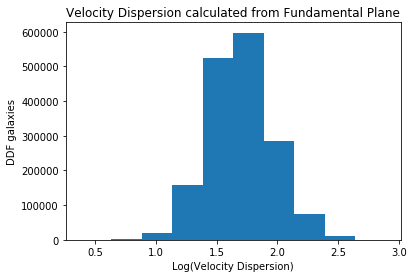

In [101]:
plt.hist(np.log10(sigma_fp))
plt.xlabel('Log(Velocity Dispersion)')
plt.ylabel('DDF galaxies')
plt.title('Velocity Dispersion calculated from Fundamental Plane')

## AGN Systems: Match to OM10

In [102]:
## Load OM10
hdulist = fits.open('../../../data/om10_qso_mock.fits')

In [103]:
om10_data = hdulist[1].data

In [104]:
# Only keep om10 systems where the host galaxy is within the redshift range of cosmoDC2
om10_data = om10_data[np.where(om10_data['ZSRC'] <= 3.0)]

In [105]:
def match_to_lenscat_agn(vel_disp, redshift, om10_array, density=1.0):
    
    """
    Match DC2 galaxies to lens galaxies in OM10 based upon velocity dispersion and redshift.
    We set the threshold for a match to be 0.03 in dex in each parameter.
    
    Parameters
    ----------
    
    vel_disp: numpy.ndarray
      Velocity dispersion (km/s) values for each cosmoDC2 galaxy that is a potential lens galaxy
      
    redshift: numpy.ndarray
      Redshifts of potential lens galaxies from cosmoDC2
      
    om10_array: FITS recarray
      OM10 Lens Catalog
      
    Returns
    -------
    
    om10_idx: List of ints
        Indices of matches in OM10 catalog from input `om10_array`
        
    lens_gal_idx: List of ints
        Indices of corresponding cosmoDC2 galaxies from catalog that provided input `vel_disp` and `redshift`
        
    om10_lens_ids: List of ints
        OM10 LENSID values for systems matched is corresponding order as other outputs
    """
        
    lens_gal_idx = []
    om10_idx = []
    
    i = 0
    successful_matches = 0
    
    for row in om10_array:

        rand_state = np.random.RandomState(row['LENSID'])
        
        if i % 500 == 0:
            print("Matched %i out of %i possible OM10 systems so far. Total Catalog Length: %i" % 
                  (successful_matches, i, len(om10_array)))
        i += 1

        lens_z = row['ZLENS']
        log_lens_z = np.log10(lens_z)
        
        lens_sigma = row['VELDISP']
        log_lens_sigma = np.log10(lens_sigma)
        
        match_prob = rand_state.uniform()
        
        # adjust matching probability for low z lenses
        # to get closer match to overall om10 in redshift and vel. disp.
        if lens_z < 0.3:
            match_prob *= 0.2
        if lens_sigma >= 225.:
            match_prob *= 0.5

        if match_prob > density:
            continue
        
        match_idx = (np.where((np.abs(log_lens_sigma - np.log10(vel_disp)) < 0.03) & 
                              (np.abs(log_lens_z - np.log10(redshift)) < 0.03)))[0]
        # Avoid duplicates
        match_idx_keep = [w for w in match_idx if w not in lens_gal_idx]
        if len(match_idx_keep) == 0:
            continue
        # Randomly choose one of the matches
        matched_lens_idx = rand_state.choice(match_idx_keep)

        lens_gal_idx.append(matched_lens_idx)
        om10_idx.append(i-1)
        successful_matches += 1
    
    om10_lens_ids = om10_array['LENSID'][om10_idx]

    return om10_idx, lens_gal_idx, om10_lens_ids

In [106]:
om10_match_idx, lens_gal_match_idx, om10_lensid = match_to_lenscat_agn(sigma_fp, 
                                                                       full_lens_join['redshift_true'], 
                                                                       om10_data, density=0.09)

Matched 0 out of 0 possible OM10 systems so far. Total Catalog Length: 11387
Matched 104 out of 500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 181 out of 1000 possible OM10 systems so far. Total Catalog Length: 11387
Matched 250 out of 1500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 318 out of 2000 possible OM10 systems so far. Total Catalog Length: 11387
Matched 379 out of 2500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 442 out of 3000 possible OM10 systems so far. Total Catalog Length: 11387
Matched 497 out of 3500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 547 out of 4000 possible OM10 systems so far. Total Catalog Length: 11387
Matched 594 out of 4500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 647 out of 5000 possible OM10 systems so far. Total Catalog Length: 11387
Matched 699 out of 5500 possible OM10 systems so far. Total Catalog Length: 11387
Matched 747 out of 600

Text(0.5, 1.0, 'Matched OM10 systems')

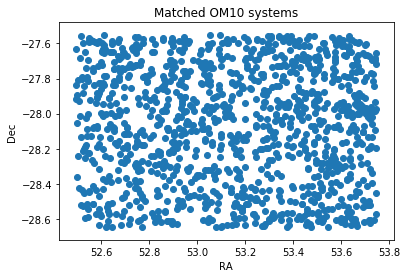

In [107]:
plt.scatter(full_lens_join['ra'][lens_gal_match_idx],
            full_lens_join['dec'][lens_gal_match_idx])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Matched OM10 systems')

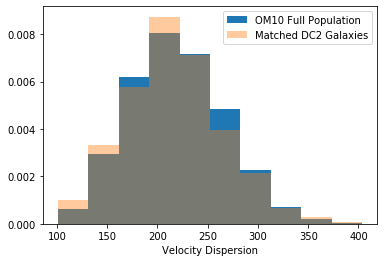

In [108]:
n, bins, _ = plt.hist(om10_data['VELDISP'], density=True, label='OM10 Full Population')
plt.hist(sigma_fp[lens_gal_match_idx], bins=bins,
         density=True, alpha=0.4, label='Matched DC2 Galaxies')
plt.xlabel('Velocity Dispersion')
plt.legend()

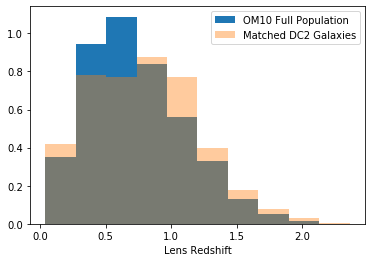

In [109]:
n, bins, _ = plt.hist(om10_data['ZLENS'], density=True, label='OM10 Full Population')
plt.hist(full_lens_join['redshift_true'][lens_gal_match_idx], bins=bins,
         density=True, alpha=0.4, label='Matched DC2 Galaxies')
plt.xlabel('Lens Redshift')
plt.legend()

In [110]:
agn_matched_ddf_lenses = full_lens_join.iloc[lens_gal_match_idx].reset_index(drop=True)

In [111]:
om10_data['LENSID'][om10_match_idx]

array([   115074,    125027,    261683, ...,  98459201,  98860610,
       100236055], dtype=int32)

In [112]:
agn_matched_ddf_lenses['LENSID'] = np.array(om10_data['LENSID'][om10_match_idx], dtype=np.int)

In [113]:
agn_matched_ddf_lenses.head()

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift,av_mw,rv_mw,fp_vel_disp,LENSID
0,17.468365,1.645144,1.0,6.116007e+10,1.632666,-0.000264,17026056.0,0.123222,1.369359,2.168065e+08,...,22.705136,22.680343,22.668815,22.665763,22.635602,0.122380,0.032723,3.1,112.573449,115074
1,16.635149,2.748216,1.0,2.049522e+11,2.743904,0.003547,8958814.0,0.136088,2.622063,2.587352e+08,...,23.139056,23.217322,23.225865,23.238564,23.211619,0.136287,0.027206,3.1,241.350794,125027
2,17.603378,1.266350,1.0,1.369300e+11,1.243201,0.001072,573002368.0,0.178592,0.834942,1.352996e+09,...,20.645668,20.690917,20.720461,20.734311,20.726107,0.179172,0.024266,3.1,208.679338,261683
3,18.646402,0.781195,1.0,2.422179e+10,0.766578,0.000242,281230816.0,0.191887,0.579925,3.689127e+07,...,21.964452,22.004111,22.013729,22.033190,22.049357,0.190084,0.022477,3.1,169.613188,394519
4,18.950142,0.618310,1.0,2.814326e+10,0.602274,0.000176,550348544.0,0.195231,0.529073,4.762166e+07,...,22.088686,22.169468,22.195342,22.208626,22.210726,0.192391,0.029738,3.1,151.699981,402741


In [114]:
agn_matched_ddf_lenses.iloc[0]

mag_true_r_lsst                                                        17.4684
size_true                                                              1.64514
sersic_disk                                                                  1
stellar_mass_bulge                                                 6.11601e+10
size_bulge_true                                                        1.63267
shear_2_phosim                                                    -0.000264414
totalStarFormationRate                                             1.70261e+07
redshift_true                                                         0.123222
size_minor_bulge_true                                                  1.36936
stellar_mass_disk                                                  2.16806e+08
dec                                                                   -28.2838
galaxy_id                                                           2562504569
shear_1                                             

In [115]:
print(om10_data[10]['ZLENS'], om10_data[10]['VELDISP'], 
      np.log10(om10_data[10]['ZLENS']), np.log10(om10_data[10]['VELDISP']),
      np.log10(agn_matched_ddf_lenses['redshift_true'].iloc[0]),
      np.log10(agn_matched_ddf_lenses['fp_vel_disp'].iloc[0]))

0.17 198.1527 -0.7695510786217261 2.296999994344255 -0.9093113494557648 2.051435970497388


In [116]:
full_lens_join_post_agn_matches = full_lens_join.drop(lens_gal_match_idx).reset_index(drop=True)

In [117]:
## To save
# agn_matched_ddf_lenses.to_csv('agn_matched_ddf_lenses.csv', index=False)

## To load
# agn_matched_ddf_lenses = pd.read_csv('agn_matched_ddf_lenses.csv')

In [25]:
### To save:
# with open('%s/sprinkler_test_code/full_lens_ddf_post_agn.pkl' % os.environ['SCRATCH'], 'wb') as f:
#     pickle.dump(full_lens_join_post_agn_matches, f)

### To load:
# with open('%s/sprinkler_test_code/full_lens_ddf_post_agn.pkl' % os.environ['SCRATCH'], 'rb') as f:
#     full_lens_join_post_agn_matches = pickle.load(f)

## SNe Systems: Match to Goldstein et al. 2019

### Load data

First we load the data from the hdf5 files with the catalogs in two tables: `system` and `image`. 
We then join the information for each image in a system to the general system properties to get one dataframe with everything in one place.

In [26]:
## Load Goldstein et al. 2019 catalog
glsne_df_system = pd.read_hdf('../../../data/glsne_dc2_v2.h5', key='system')
glsne_df_image = pd.read_hdf('../../../data/glsne_dc2_v2.h5', key='image')

In [27]:
len(glsne_df_system), len(glsne_df_image)

(196819, 491539)

In [28]:
def merge_catalog(df_sys, df_img):

    img_pivot = df_img.pivot(index='sysno', columns='imno')
    img_df = pd.DataFrame([])
    img_df['sysno'] = img_pivot.index.values
    img_df['n_img'] = np.sum(~np.isnan(img_pivot['td']), axis=1).values
    img_df['x_img'] = list(img_pivot['x'].values)
    img_df['y_img'] = list(img_pivot['y'].values)
    img_df['t_delay_img'] = list(img_pivot['td'].values)
    img_df['magnification_img'] = list(img_pivot['mu'].values)

    df_merged = df_sys.merge(img_df, on='sysno')

    return df_merged

In [29]:
glsne_merged_df = merge_catalog(glsne_df_system, glsne_df_image)

In [30]:
# Remove objects where the host galaxy is more than 1.25 arcseconds from the source so we can image it with postage stamp code
glsne_merged_df = glsne_merged_df.query('host_x < 1.25 and host_y < 1.25 and host_x > -1.25 and host_y > -1.25').reset_index(drop=True)

### Add in SNCosmo parameters

Before going further we need to add in some parameters we will need in the final truth catalogs to generate SNe in the instance catalgos.

We will fit for the SNCosmo `x0` parameter while setting `x1` to 1. and `c` to 0. for all SNe.

In [31]:
glsne_merged_df['x1'] = 1.
glsne_merged_df['c'] = 0.

In [32]:
source = sncosmo.get_source('salt2-extended')
model = sncosmo.Model(source=source)

In [33]:
## Use cosmoDC2 settings
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0, Neff=3.04, m_nu=None, Ob0=0.045)

In [34]:
x0 = []
for sn_row_zs, sn_row_mb in zip(glsne_merged_df['zs'].values, glsne_merged_df['MB'].values):
    z = sn_row_zs
    MB = sn_row_mb
    model.set(z=z)
    model.set_source_peakabsmag(MB, 'bessellb', 'ab', cosmo=cosmo)
    x0.append(model.get('x0'))

In [35]:
glsne_merged_df['x0'] = x0
print(glsne_merged_df['x0'].head().values)

[3.45494326e-06 1.86039419e-05 3.47243755e-06 6.17802354e-06
 6.54273146e-05]


Now we take a look at the data and make sure it has everything we need.

In [36]:
# Make sure max redshift is within cosmoDC2 parameters (z <= 3.0)
np.max(glsne_merged_df['zs'])

1.9987028923600352

In [37]:
glsne_merged_df.head()

,t0,sigma,gamma,e,theta_e,theta_gamma,zs,zl,snx,sny,...,t_found,lensgal_mi,n_img,x_img,y_img,t_delay_img,magnification_img,x1,c,x0
0,62986.222880,270.972759,0.040137,0.785929,349.848750,76.941654,0.812597,0.106528,0.229110,-0.578431,...,63001.066591,16.819399,4,"[1.8567313382746753, -0.6125664833399649, -1.4...","[-1.2431842777174051, -1.599762029071389, -0.9...","[0.0, 17.75014570842433, 16.481990055399315, 3...","[1.7090175165786845, -1.550573417269022, 2.942...",1.0,0.0,0.000003
1,60175.070270,168.759862,0.145709,0.704465,246.352212,103.154255,0.377906,0.036807,0.074938,-0.416329,...,60180.306487,13.786878,2,"[0.012350146535305506, -0.17819283537730632, n...","[-1.3505507330233701, 0.1706586423615417, nan,...","[0.0, 3.861514854028434, nan, nan, nan, nan, n...","[1.4285701443179548, -0.40551041722610437, nan...",1.0,0.0,0.000019
2,59748.557028,132.459490,0.017375,0.598633,58.483556,133.326378,0.760426,0.034289,0.012960,0.362303,...,59753.360582,15.279224,2,"[0.1675813762566834, 0.03591281080495878, nan,...","[0.8405698523038398, -0.10294338598613018, nan...","[0.0, 1.6208959467121609, nan, nan, nan, nan, ...","[1.6006416283312568, -0.34507143883359465, nan...",1.0,0.0,0.000003
3,61949.847395,118.022925,0.040725,0.593290,160.205181,318.665928,0.608011,0.062039,0.052200,0.120958,...,61964.966613,16.656477,4,"[-0.20925474199558802, 0.41238055985380917, -0...","[0.38785407386923954, 0.12435595220838142, -0....","[0.0027707964178567135, 0.0, 0.712846109026676...","[2.6931360351001556, 2.7664547009729747, -0.35...",1.0,0.0,0.000006
4,61115.635658,228.924462,0.078453,0.467754,193.369376,81.474409,0.223768,0.055731,-0.121008,0.485098,...,61151.090221,14.858030,2,"[0.18489088006483717, 0.13151144765516956, nan...","[1.5873449658770713, -0.4828409491709667, nan,...","[0.0, 9.744395910594474, nan, nan, nan, nan, n...","[4.610762414884782, -0.5249969643587687, nan, ...",1.0,0.0,0.000065


In [38]:
glsne_merged_df.columns

Index(['t0', 'sigma', 'gamma', 'e', 'theta_e', 'theta_gamma', 'zs', 'zl',
       'snx', 'sny', 'MB', 'transient_amplitude', 'sysno', 'sntype', 'ebvhost',
       'ra', 'dec', 'ebvmw', 'weight', 'host_n', 'host_ellip', 'host_reff',
       'host_theta', 'host_amplitude', 'host_type', 'host_x', 'host_y',
       'lensgal_n', 'lensgal_ellip', 'lensgal_reff', 'lensgal_theta',
       'lensgal_amplitude', 'lensgal_type', 'lensgal_x', 'lensgal_y',
       't_found', 'lensgal_mi', 'n_img', 'x_img', 'y_img', 't_delay_img',
       'magnification_img', 'x1', 'c', 'x0'],
      dtype='object')

In [39]:
len(full_lens_join_post_agn_matches)

1670418

In [40]:
## Discard dc2 galaxies that won't match no matter what because they are outside redshift, vel. disp range of lens catalog lenses
max_z_glsne_lens = np.power(10, np.log10(np.max(glsne_merged_df['zl'])) + 0.03)
min_vel_disp = np.power(10, np.log10(np.min(glsne_merged_df['sigma'])) - 0.03)
full_lens_join_sne_set = full_lens_join_post_agn_matches.query('redshift_true < %f and fp_vel_disp > %f' % (max_z_glsne_lens,
                                                                                                            min_vel_disp)).reset_index(drop=True)

In [41]:
len(full_lens_join_sne_set)

17725

In [42]:
def match_to_lenscat_sne(vel_disp, redshift, glsne_cat_zl, glsne_cat_sigma, glsne_cat_sysno, glsne_weights, density=1.0):
    
    """
    Match DC2 galaxies to lens galaxies in OM10 based upon velocity dispersion and redshift.
    We set the threshold for a match to be 0.03 in dex in each parameter.
    
    Parameters
    ----------
    
    vel_disp: numpy.ndarray
      Velocity dispersion (km/s) values for each cosmoDC2 galaxy that is a potential lens galaxy
      
    redshift: numpy.ndarray
      Redshifts of potential lens galaxies from cosmoDC2
      
    glsne_cat: pandas dataframe
      Catalog of Strongly Lensed SNe systems from Goldstein et al. 2019
      
    Returns
    -------
    
    glsne_idx: List of ints
        Indices of matches in glsne catalog from input `glsne_cat`
        
    lens_gal_idx: List of ints
        Indices of corresponding cosmoDC2 galaxies from catalog that provided input `vel_disp` and `redshift`
        
    glsne_lens_ids: List of ints
        glsne catalog `sysno` values for systems matched is corresponding order as other outputs
    """
        
    lens_gal_idx = []
    glsne_idx = []
    
    normed_weights = glsne_weights/np.max(glsne_weights)
    
    i = 0
    successful_matches = 0
    
    for lens_z, lens_sigma, lens_sysno, sys_weight in zip(glsne_cat_zl, glsne_cat_sigma, glsne_cat_sysno, normed_weights):
        
        rand_state = np.random.RandomState(lens_sysno)
        
        if i % 5000 == 0:
            print("Matched %i out of %i possible GLSNe systems so far. Total Catalog Length: %i" % 
                  (successful_matches, i, len(glsne_cat_zl)))
        i += 1

        log_lens_z = np.log10(lens_z)

        log_lens_sigma = np.log10(lens_sigma)
        
        match_prob = rand_state.uniform()
        match_density = density * sys_weight * 10
#         if lens_sigma > 190.:
#             match_prob = match_density - 0.01
#         if lens_z < 0.4:
#             match_prob = density - 0.01
#         if lens_sigma < 130.:
#             match_prob *= 2.

        if (match_prob > match_density):
            continue
        
        match_idx = (np.where((np.abs(log_lens_sigma - np.log10(vel_disp)) < 0.03) & 
                              (np.abs(log_lens_z - np.log10(redshift)) < 0.03)))[0]
        # Avoid duplicates
        match_idx_keep = [w for w in match_idx if w not in lens_gal_idx]
        if len(match_idx_keep) == 0:
            continue
        # Randomly choose one of the matches
        matched_lens_idx = rand_state.choice(match_idx_keep)

        lens_gal_idx.append(matched_lens_idx)
        glsne_idx.append(i-1)
        successful_matches += 1
    
    glsne_lens_ids = glsne_cat_sysno[glsne_idx]

    return glsne_idx, lens_gal_idx, glsne_lens_ids

In [43]:
glsne_match_idx, lens_gal_sne_match_idx, glsne_sysno = match_to_lenscat_sne(full_lens_join_sne_set['fp_vel_disp'].values, 
                                                                            full_lens_join_sne_set['redshift_true'].values, 
                                                                            glsne_merged_df['zl'].values,
                                                                            glsne_merged_df['sigma'].values,
                                                                            glsne_merged_df['sysno'].values,
                                                                            glsne_merged_df['weight'].values,
                                                                            density=0.85)

Matched 0 out of 0 possible GLSNe systems so far. Total Catalog Length: 154940
Matched 73 out of 5000 possible GLSNe systems so far. Total Catalog Length: 154940
Matched 153 out of 10000 possible GLSNe systems so far. Total Catalog Length: 154940
Matched 221 out of 15000 possible GLSNe systems so far. Total Catalog Length: 154940
Matched 278 out of 20000 possible GLSNe systems so far. Total Catalog Length: 154940
Matched 342 out of 25000 possible GLSNe systems so far. Total Catalog Length: 154940
Matched 392 out of 30000 possible GLSNe systems so far. Total Catalog Length: 154940
Matched 432 out of 35000 possible GLSNe systems so far. Total Catalog Length: 154940
Matched 481 out of 40000 possible GLSNe systems so far. Total Catalog Length: 154940
Matched 522 out of 45000 possible GLSNe systems so far. Total Catalog Length: 154940
Matched 563 out of 50000 possible GLSNe systems so far. Total Catalog Length: 154940
Matched 600 out of 55000 possible GLSNe systems so far. Total Catalog Len

Text(0.5, 1.0, 'Matched GLSNe systems')

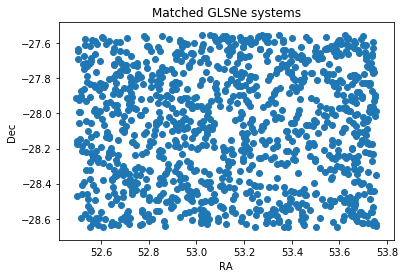

In [44]:
plt.scatter(full_lens_join_sne_set['ra'][lens_gal_sne_match_idx],
            full_lens_join_sne_set['dec'][lens_gal_sne_match_idx])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Matched GLSNe systems')

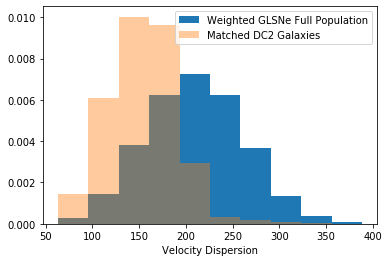

In [45]:
n, bins, _ = plt.hist(glsne_merged_df['sigma'], density=True, weights=glsne_merged_df['weight'],
                      label='Weighted GLSNe Full Population')
plt.hist(full_lens_join_sne_set['fp_vel_disp'][lens_gal_sne_match_idx], bins=bins,
         density=True, alpha=0.4, label='Matched DC2 Galaxies')
plt.xlabel('Velocity Dispersion')
plt.legend()

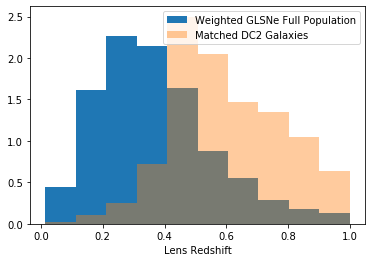

In [46]:
n, bins, _ = plt.hist(glsne_merged_df['zl'], density=True, weights=glsne_merged_df['weight'], 
                      label='Weighted GLSNe Full Population')
plt.hist(full_lens_join_sne_set['redshift_true'][lens_gal_sne_match_idx], bins=bins,
         density=True, alpha=0.4, label='Matched DC2 Galaxies')
plt.xlabel('Lens Redshift')
plt.legend()

Text(0.5, 1.0, 'First image t0')

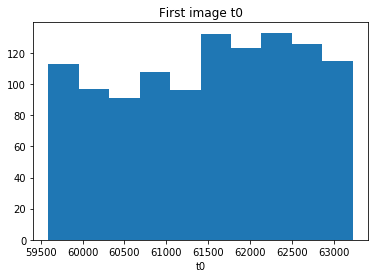

In [47]:
# Make sure we discoveries spread throughout time range
plt.hist(glsne_merged_df['t0'].iloc[glsne_match_idx])
plt.xlabel('t0')
plt.title('First image t0')

In [48]:
sne_matched_ddf_lenses = full_lens_join_sne_set.iloc[lens_gal_sne_match_idx].reset_index(drop=True)

In [49]:
sne_matched_ddf_lenses['LENSID'] = np.array(glsne_merged_df['sysno'][glsne_match_idx], dtype=np.int)

In [50]:
## To save
# sne_matched_ddf_lenses.to_csv('sne_matched_ddf_lenses.csv', index=False)

## To load
# sne_matched_ddf_lenses = pd.read_csv('sne_matched_ddf_lenses.csv')

In [51]:
# Use only the systems that matched to DDF lens galaxies
glsne_ddf_systems = glsne_merged_df.iloc[glsne_match_idx]

In [52]:
## To save
# glsne_ddf_systems.to_pickle('glsne_ddf_sys.pkl')

## To load
# glsne_ddf_systems = pd.read_pickle('glsne_ddf_sys.pkl')

## Find host galaxies for the matched systems

### AGN

Here we take the OM10 systems that matched to DDF cosmoDC2 lens galaxies will use our cache of AGN hosting cosmoDC2 galaxies and find matches for the host galaxies in the OM10 systems and assign them to be sprinkled into the DDF field.

In [119]:
# Use only the OM10 systems that matched to DDF lens galaxies
om10_ddf_systems = om10_data[om10_match_idx]

In [120]:
def match_hosts_om10(redshift, agn_i_mag, om10_systems):
    
    """
    Match host galaxies to OM10 systems based upon redshift and i-band AGN magnitude.
    
    Parameters
    ----------

    redshift: numpy ndarray
        Array of DC2 potential host redshifts
        
    agn_i_mag: numpy ndarray
        Array of DC2 potential AGN i-band magnitudes in same order as redshift
        
    om10_systems: om10 fits data table
        The subselection of OM10 that matched to a lens galaxy already
        
    Returns
    -------
    
    om10_idx: list
        Row index in input `om10_systems` that matched to a DC2 host galaxy
        
    host_gal_idx: list
        Row index in the input DC2 `redshift` and `agn_i_mag` arrays that matched to an om10 system in
        the same order as `om10_idx`
        
    om10_system_ids: list
        `LENSID` values of the om10 systems that matched to a DC2 host galaxy
    """
    
    i = 0
    om10_idx = []
    host_gal_idx = []
    
    for om10_row in om10_systems:
        rand_state = np.random.RandomState(om10_row['LENSID'])
        log_z_om10 = np.log10(om10_row['ZSRC'])
        imag_om10 = om10_row['MAGI_IN']
        
        matches = np.where((np.abs(np.log10(redshift) - log_z_om10) < 0.05) &
                           (np.abs(agn_i_mag - imag_om10) < 0.05))[0]
        keep_matches = [w for w in matches if w not in host_gal_idx]
        if len(keep_matches) > 0:
            gal_match = rand_state.choice(keep_matches)
            om10_idx.append(i)
            host_gal_idx.append(gal_match)
            
        i += 1
        
    om10_system_ids = om10_systems['LENSID'][om10_idx]
        
    return om10_idx, host_gal_idx, om10_system_ids

In [122]:
om10_index, agn_host_gal_index, om10_matched_lensid = match_hosts_om10(full_agn_host_join['redshift_true'],
                                                                       full_agn_host_join['mag_i_agn'],
                                                                       om10_ddf_systems)

In [123]:
len(om10_index), len(om10_ddf_systems)

(1056, 1199)

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 <a list of 9 Text yticklabel objects>)

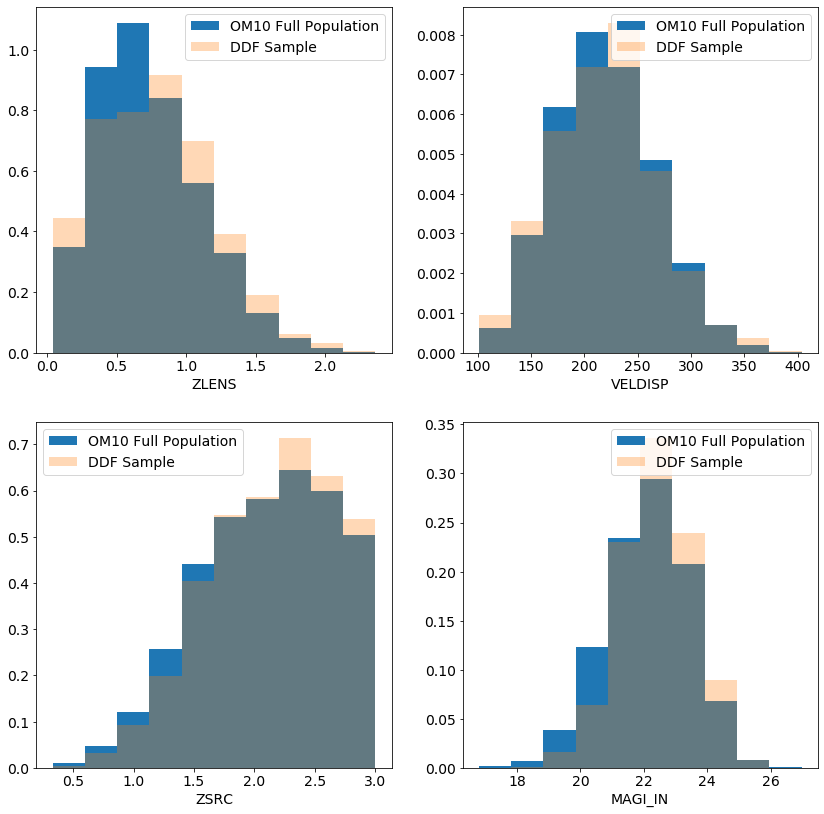

In [124]:
fig = plt.figure(figsize=(14, 14))
fig.add_subplot(2,2,1)
om10_key = 'ZLENS'
n, bins, _ = plt.hist(om10_data[om10_key], density=True, label='OM10 Full Population')
plt.hist(om10_ddf_systems[om10_key][om10_index], bins=bins, density=True, alpha=0.3, label='DDF Sample')
plt.legend(fontsize=14)
plt.xlabel(om10_key, size=14)
plt.xticks(size=14)
plt.yticks(size=14)

fig.add_subplot(2,2,2)
om10_key = 'VELDISP'
n, bins, _ = plt.hist(om10_data[om10_key], density=True, label='OM10 Full Population')
plt.hist(om10_ddf_systems[om10_key][om10_index], bins=bins, density=True, alpha=0.3, label='DDF Sample')
plt.legend(fontsize=14)
plt.xlabel(om10_key, size=14)
plt.xticks(size=14)
plt.yticks(size=14)

fig.add_subplot(2,2,3)
om10_key = 'ZSRC'
n, bins, _ = plt.hist(om10_data[om10_key], density=True, label='OM10 Full Population')
plt.hist(om10_ddf_systems[om10_key][om10_index], bins=bins, density=True, alpha=0.3, label='DDF Sample')
plt.legend(fontsize=14)
plt.xlabel(om10_key, size=14)
plt.xticks(size=14)
plt.yticks(size=14)

fig.add_subplot(2,2,4)
om10_key = 'MAGI_IN'
n, bins, _ = plt.hist(om10_data[om10_key], density=True, label='OM10 Full Population')
plt.hist(om10_ddf_systems[om10_key][om10_index], bins=bins, density=True, alpha=0.3, label='DDF Sample')
plt.legend(fontsize=14)
plt.xlabel(om10_key, size=14)
plt.xticks(size=14)
plt.yticks(size=14)

In [125]:
agn_final_ddf_lenses = agn_matched_ddf_lenses.iloc[om10_index]

In [126]:
agn_final_ddf_lenses.head()

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift,av_mw,rv_mw,fp_vel_disp,LENSID
0,17.468365,1.645144,1.0,6.116007e+10,1.632666,-0.000264,17026056.0,0.123222,1.369359,216806464.0,...,22.705136,22.680343,22.668815,22.665763,22.635602,0.122380,0.032723,3.1,112.573449,115074
1,16.635149,2.748216,1.0,2.049522e+11,2.743904,0.003547,8958814.0,0.136088,2.622063,258735200.0,...,23.139056,23.217322,23.225865,23.238564,23.211619,0.136287,0.027206,3.1,241.350794,125027
3,18.646402,0.781195,1.0,2.422179e+10,0.766578,0.000242,281230816.0,0.191887,0.579925,36891268.0,...,21.964452,22.004111,22.013729,22.033190,22.049357,0.190084,0.022477,3.1,169.613188,394519
4,18.950142,0.618310,1.0,2.814326e+10,0.602274,0.000176,550348544.0,0.195231,0.529073,47621660.0,...,22.088686,22.169468,22.195342,22.208626,22.210726,0.192391,0.029738,3.1,151.699981,402741
5,17.150339,2.505291,1.0,2.544800e+11,2.501296,-0.000248,25334280.0,0.189025,2.361300,317852608.0,...,23.131474,23.155779,23.192933,23.214137,23.201177,0.187727,0.020009,3.1,263.023551,421360


In [127]:
agn_final_ddf_hosts = full_agn_host_join.iloc[agn_host_gal_index].reset_index(drop=True)

In [128]:
agn_final_ddf_hosts['LENSID'] = np.array(om10_matched_lensid, dtype=np.int)

In [129]:
agn_final_ddf_hosts.head()

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift_sed,LENSID
0,22.257313,0.588199,1.0,9.054468e+10,0.588199,-0.009852,1.430286e+10,1.156462,0.386820,0.072557,...,22.070617,22.056662,50.765290,50.758585,50.737682,50.819550,50.821822,50.832280,1.155176,115074
1,24.334911,0.255512,1.0,2.686980e+10,0.255512,0.003897,1.636498e+09,2.229488,0.193343,1847.854980,...,24.145999,24.116426,40.531886,40.382264,40.349384,40.334251,40.324361,40.316640,2.216846,125027
2,26.975149,0.409687,1.0,3.831434e+10,0.409687,-0.017488,5.378232e+08,2.997010,0.405581,2.774903,...,25.023311,25.288215,47.983371,48.418324,48.265839,48.249303,48.253655,48.246300,2.998385,394519
3,23.420465,0.352481,1.0,1.235421e+11,0.352481,0.009630,1.602911e+10,2.153988,0.294515,0.664951,...,23.409228,23.387915,49.891028,49.755610,49.730910,49.720396,49.712162,49.712941,2.149818,402741
4,21.939037,0.702844,1.0,1.704949e+11,0.702844,-0.000355,2.449368e+10,1.300650,0.589169,0.015978,...,21.868808,21.953792,52.122737,52.094882,52.078106,52.117926,52.034562,52.159474,1.303937,421360


In [130]:
om10_ddf_final = om10_ddf_systems[om10_index]

In [5]:
## To save:
# agn_final_ddf_hosts.to_csv('%s/agn_final_ddf_hosts.csv' % os.environ['SCRATCH'], index=False)
# agn_final_ddf_lenses.to_csv('%s/agn_final_ddf_lenses.csv' % os.environ['SCRATCH'], index=False)

## To load:
agn_final_ddf_hosts = pd.read_csv('%s/agn_final_ddf_hosts.csv' % os.environ['SCRATCH'])
agn_final_ddf_lenses = pd.read_csv('%s/agn_final_ddf_lenses.csv' % os.environ['SCRATCH'])

In [132]:
om10_final_tbhdu = fits.BinTableHDU(om10_ddf_final)

In [6]:
## To save:
# if os.path.exists('%s/om10_ddf_final.fits' % os.environ['SCRATCH']):
#     os.remove('%s/om10_ddf_final.fits' % os.environ['SCRATCH'])
# om10_final_tbhdu.writeto('%s/om10_ddf_final.fits' % os.environ['SCRATCH'])

## To load:
om10_final_tbhdu = fits.open('%s/om10_ddf_final.fits' % os.environ['SCRATCH'])

### SNe

Do the same for SNe galaxies.

In [53]:
def match_hosts_glsne(redshift, host_size, glsne_redshifts, glsne_host_size, glsne_sysno):
    
    """
    Match host galaxies to GLSNE systems based upon redshift
    
    Parameters
    ----------

    redshift: numpy ndarray
        Array of DC2 potential host redshifts
        
    glsne_redshifts: numpy ndarray
        The redshifts from the subselection of GLSNe that matched to a lens galaxy already
        
    glsne_sysno: numpy ndarray
        The system numbers of the subselection of GLSNe that matched to a lens galaxy already
        
    Returns
    -------
    
    glsne_idx: list
        Row index in input `glsne_redshift` and `glsne_sysno` that matched to a DC2 host galaxy
        
    host_gal_idx: list
        Row index in the input DC2 `redshift` array that matched to a glsne system in
        the same order as `glsne_idx`
        
    glsne_system_ids: list
        `glsne_sysno` values of the glsne systems that matched to a DC2 host galaxy
    """
    
    i = 0
    glsne_idx = []
    host_gal_idx = []
    
    for glsne_z, glsne_size, row_sysno in zip(glsne_redshifts, glsne_host_size, glsne_sysno):
        rand_state = np.random.RandomState(row_sysno)
        log_z_glsne = np.log10(glsne_z)
        log_size_glsne = np.log10(glsne_size)
                
        if i % 50 == 0:
            print(i)
        
        matches = np.where((np.abs(np.log10(redshift) - log_z_glsne) < 0.05) &
                           (np.abs(np.log10(host_size) - log_size_glsne) < 0.05))[0]
        keep_matches = [w for w in matches if w not in host_gal_idx]
        if len(keep_matches) > 0:
            gal_match = rand_state.choice(keep_matches)
            glsne_idx.append(i)
            host_gal_idx.append(gal_match)
            
        i += 1
        
        glsne_system_ids = glsne_sysno[glsne_idx]
        
    return glsne_idx, host_gal_idx, glsne_system_ids

In [54]:
glsne_index, sne_host_gal_index, glsne_matched_lensid = match_hosts_glsne(full_sne_host_join['redshift_true'],
                                                                          full_sne_host_join['size_true'],
                                                                          glsne_ddf_systems['zs'].values,
                                                                          glsne_ddf_systems['host_reff'],
                                                                          glsne_ddf_systems['sysno'].values)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100


In [55]:
len(glsne_index), len(glsne_ddf_systems)

(1029, 1134)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 <a list of 9 Text yticklabel objects>)

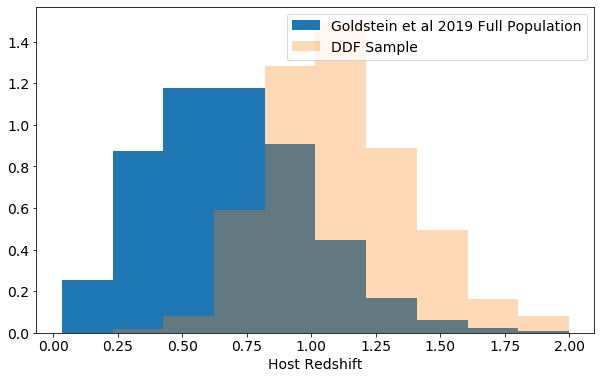

In [56]:
fig = plt.figure(figsize=(10, 6))
n, bins, _ = plt.hist(glsne_merged_df['zs'], density=True, label='Goldstein et al 2019 Full Population')
plt.hist(glsne_ddf_systems['zs'].iloc[glsne_index], bins=bins, density=True, alpha=0.3, label='DDF Sample')
plt.legend(fontsize=14)
plt.xlabel('Host Redshift', size=14)
plt.xticks(size=14)
plt.yticks(size=14)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8]),
 <a list of 10 Text yticklabel objects>)

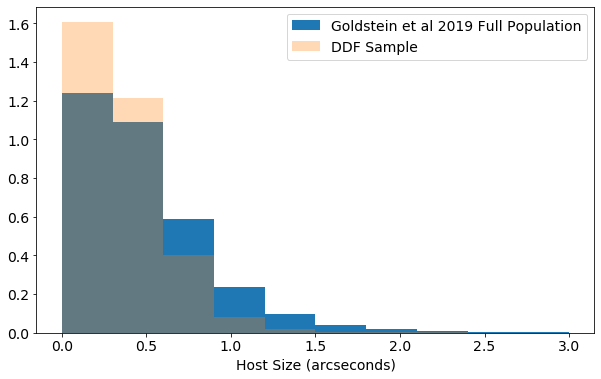

In [57]:
fig = plt.figure(figsize=(10, 6))
n, bins, _ = plt.hist(glsne_merged_df['host_reff'], density=True, label='Goldstein et al 2019 Full Population', range=(0,3))
plt.hist(glsne_ddf_systems['host_reff'].iloc[glsne_index], bins=bins, density=True, alpha=0.3, label='DDF Sample', range=(0,3))
plt.legend(fontsize=14)
plt.xlabel('Host Size (arcseconds)', size=14)
plt.xticks(size=14)
plt.yticks(size=14)

In [58]:
sne_final_ddf_lenses = sne_matched_ddf_lenses.iloc[glsne_index]

In [59]:
sne_final_ddf_lenses.head()

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift,av_mw,rv_mw,fp_vel_disp,LENSID
0,20.521349,0.461294,1.0,5.455395e+09,0.460195,0.000871,1.358046e+05,0.243622,0.437576,5.797736e+06,...,27.013948,26.913123,26.961043,26.988785,26.982579,0.243440,0.021971,3.1,115.848434,81692
1,20.812342,0.845988,1.0,1.058162e+11,0.845988,0.003371,9.673319e+06,0.497189,0.503059,2.667691e-01,...,47.254767,47.269292,47.295633,47.338026,47.341911,0.498965,0.024149,3.1,176.257202,91135
2,20.593390,0.435176,1.0,5.849901e+10,0.435176,-0.000907,1.215823e+04,0.450571,0.390457,4.382401e+00,...,43.611880,43.606520,43.613058,43.635543,43.624046,0.449370,0.027704,3.1,193.334022,71895
3,22.466885,0.680219,1.0,1.997431e+10,0.677229,-0.013754,7.592423e+09,0.866809,0.591077,9.126680e+07,...,28.300788,28.265599,28.240269,28.232998,28.259103,0.861225,0.021188,3.1,169.330047,97435
4,19.202448,0.868611,1.0,1.227533e+11,0.866587,-0.000965,2.437268e+08,0.325088,0.729261,1.384809e+08,...,24.108969,24.104839,24.131152,24.151765,24.160617,0.325335,0.024960,3.1,203.183891,20267


In [60]:
sne_final_ddf_hosts = full_sne_host_join.iloc[sne_host_gal_index].reset_index(drop=True)

In [61]:
sne_final_ddf_hosts['LENSID'] = np.array(glsne_matched_lensid, dtype=np.int)

In [62]:
sne_final_ddf_hosts.head()

,mag_true_r_lsst,size_true,sersic_disk,stellar_mass_bulge,size_bulge_true,shear_2_phosim,totalStarFormationRate,redshift_true,size_minor_bulge_true,stellar_mass_disk,...,bulge_magnorm_z,bulge_magnorm_y,disk_magnorm_u,disk_magnorm_g,disk_magnorm_r,disk_magnorm_i,disk_magnorm_z,disk_magnorm_y,redshift_sed,LENSID
0,25.792505,0.231861,1.0,2.293087e+07,0.113314,-0.009798,3.554612e+06,0.978356,0.092451,1.742619e+08,...,28.033854,28.003674,25.418367,25.323984,25.294284,25.236405,25.245956,25.236197,0.979002,81692
1,28.429279,0.116454,1.0,1.932878e+05,0.052918,0.002411,2.314672e+04,0.735751,0.052642,1.949605e+06,...,30.730908,30.698554,27.968355,27.898107,28.018597,28.148853,28.190497,28.219406,0.735664,91135
2,22.812323,0.685571,1.0,1.425064e+10,0.481559,0.010535,5.830747e+09,0.816591,0.444398,2.018835e+09,...,22.966027,23.009390,22.683126,22.671795,22.659430,22.685340,22.716021,22.734276,0.822728,71895
3,26.534029,0.435495,1.0,1.751642e+08,0.193527,-0.008137,3.442237e+06,1.391150,0.190296,9.927155e+08,...,27.487332,27.410447,24.983197,24.989256,25.074275,25.237377,25.284350,25.286772,1.394258,97435
4,27.813845,0.120334,1.0,1.746502e+06,0.069144,0.003650,1.423695e+04,0.680693,0.068040,1.531222e+06,...,28.480747,28.491906,27.875762,27.951912,27.966541,28.069001,28.117080,28.140400,0.680624,20267


In [63]:
glsne_ddf_final = glsne_ddf_systems.iloc[glsne_index]

In [2]:
## To save:
# sne_final_ddf_hosts.to_csv('%s/sne_final_ddf_hosts.csv' % os.environ['SCRATCH'], index=False)
# sne_final_ddf_lenses.to_csv('%s/sne_final_ddf_lenses.csv' % os.environ['SCRATCH'], index=False)

## To load:
# sne_final_ddf_hosts = pd.read_csv('%s/sne_final_ddf_hosts.csv' % os.environ['SCRATCH'])
# sne_final_ddf_lenses = pd.read_csv('%s/sne_final_ddf_lenses.csv' % os.environ['SCRATCH'])

In [3]:
## To save:
# glsne_ddf_final.to_pickle('%s/glsne_ddf_final.pkl' % os.environ['SCRATCH'])

## To load:
# glsne_ddf_final = pd.read_pickle('%s/glsne_ddf_final.pkl' % os.environ['SCRATCH'])

## Add Fluxes

The truth catalog schema outlined for requires fluxes with and without corrections for Milky Way Extinction. To have complete truth catalogs we'll add these in for our hosts and AGN. Since the lenses are already in the simulations they have complete truth catalog information in the main truth catalog.

In [6]:
def add_flux(sed_name, redshift, magnorm_dict, av, rv, bp_dict=None):
    
    if bp_dict is None:
        bp_dict = BandpassDict.loadTotalBandpassesFromFiles()
        
    result_dict_no_mw = {}
    result_dict_mw = {}
    
    sed_obj = Sed()
    sed_obj.readSED_flambda(os.path.join(os.environ['SIMS_SED_LIBRARY_DIR'], sed_name))
    a_x, b_x = sed_obj.setupCCM_ab()
    for bandpass_name in bp_dict.keys():
        sed_copy = deepcopy(sed_obj)
        flux_norm = getImsimFluxNorm(sed_copy, magnorm_dict[bandpass_name])
        sed_copy.multiplyFluxNorm(flux_norm)
        sed_copy.redshiftSED(redshift, dimming=True)
        band_flux = sed_copy.calcFlux(bp_dict[bandpass_name])
        result_dict_no_mw[bandpass_name] = band_flux
        sed_copy.addDust(a_x, b_x, A_v=av, R_v=rv)
        band_flux_mw = sed_copy.calcFlux(bp_dict[bandpass_name])
        result_dict_mw[bandpass_name] = band_flux_mw
        
    return result_dict_no_mw, result_dict_mw

## Create truth catalogs

Here we create separate truth catalogs for the lenses, lensed hosts and lensed AGN. For the lenses, the photometry information is left out since it should be in the full WFD truth catalogs. To match up all the truth catalogs we can use `dc2_sys_id` to cross reference.

In [78]:
def create_lens_truth_dataframe(matched_lenses, matched_sys_cat, id_type_prefix):
    
    """
    Create the final properly formatted lens galaxy truth catalog.
    
    Parameters
    ----------
    matched_lenses: pandas dataframe
        Dataframe of matched DC2 lenses
        
    matched_sys_cat: pandas dataframe
        Dataframe of matched lens catalog systems
        
    id_type_prefix: str
        Ids to match systems will be (id_type_prefix)_(lens sys id number)
        Example: `GLAGN_0`
        
    Returns
    -------
    lens_df: pandas dataframe
        Return the pandas dataframe format of the truth catalog.
    """

    new_entries = []

    for i in range(len(matched_sys_cat)):

        gal_id = matched_lenses.iloc[i]['galaxy_id']
        new_sys_id_num = i
        new_sys_id = '%s_%i' % (id_type_prefix, new_sys_id_num)
        # The newly inserted lens galaxy keeps the old gal_id
        unique_id = gal_id

        ra_lens = matched_lenses.iloc[i]['ra']
        dec_lens = matched_lenses.iloc[i]['dec']

        redshift = matched_sys_cat.iloc[i]['z_lens']
        shear_1_dc2 = matched_lenses.iloc[i]['gamma_1']
        shear_2_dc2 = matched_lenses.iloc[i]['gamma_2']
        kappa_dc2 = matched_lenses.iloc[i]['kappa']
        gamma_lenscat = matched_sys_cat.iloc[i]['gamma']
        phi_gamma_lenscat = matched_sys_cat.iloc[i]['phi_gamma']
        shear_1_lenscat = gamma_lenscat * np.cos(2 * phi_gamma_lenscat)
        shear_2_lenscat = gamma_lenscat * np.sin(2 * phi_gamma_lenscat)
        sindex_lens = 4

#         major_axis_lens = matched_sys_cat.iloc[i]['reff_lens'] / \
#                             np.sqrt(1 - matched_sys_cat.iloc[i]['ellip_lens'])
#         minor_axis_lens = matched_sys_cat.iloc[i]['reff_lens'] * \
#                             np.sqrt(1 - matched_sys_cat.iloc[i]['ellip_lens'])
#         position_angle = matched_sys_cat.iloc[i]['phie_lens']*(-1.0)*np.pi/180.0
        major_axis_lens = matched_lenses.iloc[i]['size']
        minor_axis_lens = matched_lenses.iloc[i]['size_minor']
        position_angle = matched_lenses.iloc[i]['position_angle']

        # Change dc2 ellip [(1-q)/(1+q)] to om10 ellipticity which is (1-q)
        q = minor_axis_lens/major_axis_lens
        ellip_dc2 = 1.0 - q
        ellip_lens = matched_sys_cat.iloc[i]['ellip_lens']
        # Convert DC2 position angle to `phie` which starts from y-axis
        phie_dc2 = 0.5*position_angle - 90
        phie_lens = matched_sys_cat.iloc[i]['phie_lens']

        av_mw = matched_lenses.iloc[i]['av_mw']
        rv_mw = matched_lenses.iloc[i]['rv_mw']

        vel_disp_lens = matched_lenses.iloc[i]['fp_vel_disp']

        cat_sys_id = matched_sys_cat.iloc[i]['system_id']

        new_row = [unique_id, ra_lens, dec_lens,
                   redshift, shear_1_dc2, shear_2_dc2, kappa_dc2, 
                   gamma_lenscat, phi_gamma_lenscat, 
                   shear_1_lenscat, shear_2_lenscat, sindex_lens,
                   major_axis_lens, minor_axis_lens,
                   position_angle, ellip_dc2, ellip_lens, phie_dc2, phie_lens, 
                   av_mw, rv_mw, vel_disp_lens,
                   cat_sys_id, new_sys_id]

        new_entries.append(new_row)

    lens_df = pd.DataFrame(new_entries, 
                           columns=['unique_id', 'ra_lens', 'dec_lens',
                                    'redshift', 'shear_1_cosmodc2', 'shear_2_cosmodc2',
                                    'kappa_cosmodc2', 'gamma_lenscat', 'phig_lenscat',
                                    'shear_1_lenscat', 'shear_2_lenscat',
                                    'sindex_lens', 'major_axis_lens',
                                    'minor_axis_lens', 'position_angle', 'ellip_cosmodc2',
                                    'ellip_lens', 'phie_cosmodc2', 'phie_lens', 'av_mw', 'rv_mw',
                                    'vel_disp_lenscat', 
                                    'lens_cat_sys_id', 'dc2_sys_id'])

    return lens_df

In [79]:
def output_lens_galaxy_truth(matched_agn_lens, matched_agn_sys,
                             matched_sne_lens, matched_sne_sys, out_file,
                             return_df=False, overwrite_existing=False):

    """
    Output sqlite truth catalogs for foreground lens galaxies for
    lensed AGN and SNe.
    
    Parameters
    ----------
    matched_agn_lens: pandas dataframe
        Dataframe of matched DC2 lenses for lensed AGN systems
        
    matched_agn_sys: pandas dataframe
        Dataframe of matched lens catalog systems for lensed AGN systems
        
    matched_sne_lens: pandas dataframe
        Dataframe of matched DC2 lenses for lensed SNe systems
        
    matched_sne_sys: pandas dataframe
        Dataframe of matched lens catalog systems for lensed SNe systems
        
    out_file: str
        Filename of sqlite truth catalog for lens galaxies
        
    return_df: bool, deafult=False
        Return the dataframes of the lens galaxy truth catalogs.
        
    overwrite_existing: bool, default=False
        Overwrite existing catalog
        
    Returns
    -------
    agn_lens_df: pandas dataframe
        Pandas dataframe format of the truth catalog for the lens galaxies in lensed AGN systems.
    
    sne_lens_df: pandas dataframe
        Pandas dataframe format of the truth catalog for the lens galaxies in lensed SNe systems.
    """

    agn_lens_df = create_lens_truth_dataframe(matched_agn_lens,
                                                   matched_agn_sys, 'GLAGN')
    sne_lens_df = create_lens_truth_dataframe(matched_sne_lens,
                                                   matched_sne_sys, 'GLSNE')
    
    if overwrite_existing is True and os.path.exists(out_file):
        os.remove(out_file)

    engine = create_engine('sqlite:///%s' % out_file, echo=False)
    agn_lens_df.to_sql('agn_lens', con=engine)
    sne_lens_df.to_sql('sne_lens', con=engine)

    if return_df is True:
        return agn_lens_df, sne_lens_df

In [3]:
om10_ddf_fits = OM10Reader('%s/om10_ddf_final.fits' % os.environ['SCRATCH'])
om10_ddf_sprinkler_cat = pd.DataFrame(om10_ddf_fits.load_catalog())

In [81]:
agn_final_ddf_lenses = agn_final_ddf_lenses.rename(columns={'shear_1': 'gamma_1', 
                                                            'shear_2_phosim':'gamma_2',
                                                            'size_true':'size',
                                                            'size_minor_true':'size_minor',
                                                            'convergence':'kappa',
                                                            'position_angle_true':'position_angle',})

In [82]:
sne_final_ddf_lenses = sne_final_ddf_lenses.rename(columns={'shear_1': 'gamma_1', 
                                                            'shear_2_phosim':'gamma_2',
                                                            'size_true':'size',
                                                            'size_minor_true':'size_minor',
                                                            'convergence':'kappa',
                                                            'position_angle_true':'position_angle',})

In [83]:
om10_ddf_sprinkler_cat.columns

Index(['system_id', 'z_src', 'mag_i_src', 'n_img', 'x_img', 'y_img', 'x_src',
       'y_src', 't_delay_img', 'magnification_img', 'z_lens', 'reff_lens',
       'ellip_lens', 'phie_lens', 'vel_disp_lens', 'gamma', 'phi_gamma'],
      dtype='object')

In [84]:
glsne_ddf_final.columns

Index(['t0', 'sigma', 'gamma', 'ellip_lens', 'phie_lens', 'phi_gamma', 'z_src',
       'z_lens', 'snx', 'sny', 'MB', 'transient_amplitude', 'system_id',
       'sntype', 'ebvhost', 'ra', 'dec', 'ebvmw', 'weight', 'host_n',
       'host_ellip', 'host_reff', 'host_theta', 'host_amplitude', 'host_type',
       'x_src', 'y_src', 'lensgal_n', 'lensgal_ellip', 'lensgal_reff',
       'lensgal_theta', 'lensgal_amplitude', 'lensgal_type', 'lensgal_x',
       'lensgal_y', 't_found', 'lensgal_mi', 'n_img', 'x_img', 'y_img',
       't_delay_img', 'magnification_img', 'x1', 'c', 'x0'],
      dtype='object')

In [85]:
om10_ddf_sprinkler_cat = om10_ddf_sprinkler_cat.rename(columns={'ZLENS':'z_lens', 'PHIE':'phie_lens'})

In [86]:
glsne_ddf_final = glsne_ddf_final.rename(columns={'zl':'z_lens', 
                                                  'sysno':'system_id', 
                                                  'theta_gamma': 'phi_gamma',
                                                  'host_x': 'x_src',
                                                  'host_y': 'y_src',
                                                  'zs':'z_src',
                                                  'e':'ellip_lens',
                                                  'theta_e':'phie_lens'})

In [87]:
agn_lens_truth, sne_lens_truth = output_lens_galaxy_truth(agn_final_ddf_lenses, om10_ddf_sprinkler_cat,
                                                          sne_final_ddf_lenses, glsne_ddf_final, 'lens_truth.db',
                                                          return_df=True, overwrite_existing=True)

In [27]:
agn_lens_truth.head()

,unique_id,ra_lens,dec_lens,redshift,shear_1_cosmodc2,shear_2_cosmodc2,kappa_cosmodc2,gamma_lenscat,phig_lenscat,shear_1_lenscat,...,minor_axis_lens,position_angle,ellip_cosmodc2,ellip_lens,phie,av_mw,rv_mw,vel_disp_lenscat,lens_cat_sys_id,dc2_sys_id
0,2562504569,53.494338,-28.283780,0.128,0.000016,-0.000264,0.001945,0.075103,122.00650,0.038586,...,1.375993,133.280980,0.163603,0.243252,-23.359510,0.032723,3.1,112.573449,115074,GLAGN_0
1,1875009351,52.567069,-27.584335,0.130,0.003029,0.003547,0.002012,0.136873,111.19370,-0.107651,...,2.622937,141.221704,0.045586,0.189070,-19.389148,0.027206,3.1,241.350794,125027,GLAGN_1
2,2562528494,53.642185,-28.561801,0.194,0.001212,0.000242,-0.001084,0.071666,-12.39478,0.067487,...,0.584852,49.829793,0.251337,0.066543,-65.085103,0.022477,3.1,169.613188,394519,GLAGN_2
3,2562528278,53.726626,-28.060437,0.196,-0.000366,0.000176,-0.000318,0.032953,19.85506,-0.014042,...,0.542555,120.036180,0.122520,0.196803,-29.981910,0.029738,3.1,151.699981,402741,GLAGN_3
4,2562527873,53.412116,-27.981824,0.198,-0.001459,-0.000248,-0.000117,0.059601,-168.31550,-0.052850,...,2.363083,79.111715,0.056763,0.465989,-50.444143,0.020009,3.1,263.023551,421360,GLAGN_4


In [28]:
sne_lens_truth.head()

,unique_id,ra_lens,dec_lens,redshift,shear_1_cosmodc2,shear_2_cosmodc2,kappa_cosmodc2,gamma_lenscat,phig_lenscat,shear_1_lenscat,...,minor_axis_lens,position_angle,ellip_cosmodc2,ellip_lens,phie,av_mw,rv_mw,vel_disp_lenscat,lens_cat_sys_id,dc2_sys_id
0,2562562017,53.535526,-28.075764,0.252611,0.000143,0.000871,-0.001513,0.012585,293.592888,-0.012052,...,0.438117,148.144613,0.050243,0.519536,-15.927693,0.021971,3.1,115.848434,81692,GLSNE_0
1,1875368496,52.835881,-27.813154,0.525968,-0.002965,0.003371,0.003681,0.095617,17.190400,-0.094128,...,0.503059,93.848551,0.405360,0.578470,-43.075724,0.024149,3.1,176.257202,91135,GLSNE_1
2,2562795013,53.051810,-28.601275,0.460236,0.001029,-0.000907,-0.004881,0.070649,130.854590,-0.040693,...,0.390457,146.359693,0.102762,0.403688,-16.820154,0.027704,3.1,193.334022,71895,GLSNE_2
3,2564204966,53.539585,-28.523730,0.853114,0.011204,-0.013754,0.004289,0.091288,356.750037,-0.085483,...,0.593025,60.884466,0.128185,0.280782,-59.557767,0.021188,3.1,169.330047,97435,GLSNE_3
4,1875114990,52.572446,-27.837023,0.336328,0.009577,-0.000965,-0.000983,0.040763,129.601132,-0.000851,...,0.727380,6.786309,0.162594,0.095485,-86.606846,0.024960,3.1,203.183891,20267,GLSNE_4


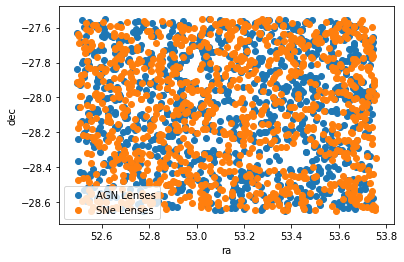

In [29]:
# Check positions
plt.scatter(agn_lens_truth['ra_lens'], agn_lens_truth['dec_lens'], label='AGN Lenses')
plt.scatter(sne_lens_truth['ra_lens'], sne_lens_truth['dec_lens'], label='SNe Lenses')
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

In [30]:
def merge_labelled_columns(df_merged, label):

    labelled_columns = ['%s_u' %label,
                        '%s_g' %label,
                        '%s_r' %label,
                        '%s_i' %label,
                        '%s_z' %label,
                        '%s_y' %label]

    label_array = df_merged[labelled_columns].values
    label_dict = {x: y for x, y in zip(['u', 'g', 'r', 'i', 'z', 'y'], df_merged[labelled_columns])}

    return label_array, label_dict

In [43]:
def create_host_truth_dataframe(matched_lenses, matched_hosts, matched_sys_cat, id_type_prefix):

    """
    Create the final properly formatted lens galaxy truth catalog.
    
    Parameters
    ----------
    matched_lenses: pandas dataframe
        Dataframe of matched DC2 lenses
        
    matched_hosts: pandas dataframe
        Dataframe of matched DC2 hosts
        
    matched_sys_cat: pandas dataframe
        Dataframe of matched lens catalog systems
        
    id_type_prefix: str
        Ids to match systems will be (id_type_prefix)_(lens sys id number)
        Example: `GLAGN_0`
        
    Returns
    -------
    host_df: pandas dataframe
        Return the pandas dataframe format of the truth catalog.
    """
 
    
    new_entries = []
    
    bp_dict = BandpassDict.loadTotalBandpassesFromFiles()

    for i in range(len(matched_sys_cat)):
        for j in range(matched_sys_cat.iloc[i]['n_img']):

            gal_id = matched_hosts.iloc[i]['galaxy_id']+j
            new_sys_id_num = i
            new_sys_id = '%s_%i' % (id_type_prefix, new_sys_id_num)
            image_number = j
            unique_id = '%s_host_%i_%i' % (id_type_prefix, new_sys_id_num, image_number)

            ra_lens = matched_lenses.iloc[i]['ra']
            dec_lens = matched_lenses.iloc[i]['dec']
            id_lens = matched_lenses.iloc[i]['galaxy_id']

            x_src = matched_sys_cat.iloc[i]['x_src']
            y_src = matched_sys_cat.iloc[i]['y_src']
            x_img = matched_sys_cat.iloc[i]['x_img'][j]
            y_img = matched_sys_cat.iloc[i]['y_img'][j]

            delta_ra = np.radians(x_img / 3600.0)
            delta_dec = np.radians(y_img / 3600.0)
            ra_host = ra_lens + delta_ra/np.cos(dec_lens)
            dec_host = dec_lens + delta_dec
            
            redshift = matched_sys_cat.iloc[i]['z_src']
            shear_1 = 0. #matched_hosts.iloc[i]['gamma_1']
            shear_2 = 0. #matched_hosts.iloc[i]['gamma_2']
            kappa = 0. #matched_hosts.iloc[i]['kappa']
            sindex_bulge = 4
            sindex_disk = 1
            
            mag_adjust = 2.5*np.log10(np.abs(matched_sys_cat.iloc[i]['magnification_img'][j]))
            magnorm_disk_array, magnorm_disk_dict = merge_labelled_columns(matched_hosts.iloc[i], 'disk_magnorm')
            # Postage stamp code expects unlensed mag
            magnorm_disk = magnorm_disk_array #- mag_adjust
            magnorm_disk_u = magnorm_disk[0]
            magnorm_disk_g = magnorm_disk[1]
            magnorm_disk_r = magnorm_disk[2]
            magnorm_disk_i = magnorm_disk[3]
            magnorm_disk_z = magnorm_disk[4]
            magnorm_disk_y = magnorm_disk[5]
            
            disk_flux_no_mw, disk_flux_mw = add_flux(matched_hosts.iloc[i]['sed_disk'][2:-1],
                                                     redshift, 
                                                     magnorm_disk_dict, matched_lenses.iloc[i]['av_mw'],
                                                     matched_lenses.iloc[i]['rv_mw'], bp_dict=bp_dict)
            
            magnorm_bulge_array, magnorm_bulge_dict = merge_labelled_columns(matched_hosts.iloc[i], 'bulge_magnorm')
            magnorm_bulge = magnorm_bulge_array #- mag_adjust
            magnorm_bulge_u = magnorm_bulge[0]
            magnorm_bulge_g = magnorm_bulge[1]
            magnorm_bulge_r = magnorm_bulge[2]
            magnorm_bulge_i = magnorm_bulge[3]
            magnorm_bulge_z = magnorm_bulge[4]
            magnorm_bulge_y = magnorm_bulge[5]
            
            bulge_flux_no_mw, bulge_flux_mw = add_flux(matched_hosts.iloc[i]['sed_bulge'][2:-1],
                                                       redshift, 
                                                       magnorm_bulge_dict, matched_lenses.iloc[i]['av_mw'],
                                                       matched_lenses.iloc[i]['rv_mw'], bp_dict=bp_dict)
            
            flux_u = bulge_flux_mw['u'] + disk_flux_mw['u']
            flux_g = bulge_flux_mw['g'] + disk_flux_mw['g']
            flux_r = bulge_flux_mw['r'] + disk_flux_mw['r']
            flux_i = bulge_flux_mw['i'] + disk_flux_mw['i']
            flux_z = bulge_flux_mw['z'] + disk_flux_mw['z']
            flux_y = bulge_flux_mw['y'] + disk_flux_mw['y']
            
            flux_u_noMW = bulge_flux_no_mw['u'] + disk_flux_no_mw['u']
            flux_g_noMW = bulge_flux_no_mw['g'] + disk_flux_no_mw['g']
            flux_r_noMW = bulge_flux_no_mw['r'] + disk_flux_no_mw['r']
            flux_i_noMW = bulge_flux_no_mw['i'] + disk_flux_no_mw['i']
            flux_z_noMW = bulge_flux_no_mw['z'] + disk_flux_no_mw['z']
            flux_y_noMW = bulge_flux_no_mw['y'] + disk_flux_no_mw['y']

            major_axis_disk = matched_hosts.iloc[i]['semi_major_axis_disk']
            major_axis_bulge = matched_hosts.iloc[i]['semi_major_axis_bulge']
            minor_axis_disk = matched_hosts.iloc[i]['semi_minor_axis_disk']
            minor_axis_bulge = matched_hosts.iloc[i]['semi_minor_axis_bulge']
            major_axis = matched_hosts.iloc[i]['semi_major_axis']
            minor_axis = matched_hosts.iloc[i]['semi_minor_axis']
            position_angle = matched_hosts.iloc[i]['position_angle']

            av_internal_disk = matched_hosts.iloc[i]['av_internal_disk']
            av_internal_bulge = matched_hosts.iloc[i]['av_internal_bulge']
            rv_internal_disk = matched_hosts.iloc[i]['rv_internal_disk']
            rv_internal_bulge = matched_hosts.iloc[i]['rv_internal_bulge']
            av_mw = matched_lenses.iloc[i]['av_mw']
            rv_mw = matched_lenses.iloc[i]['rv_mw']

            sed_disk_host = matched_hosts.iloc[i]['sed_disk']
            sed_bulge_host = matched_hosts.iloc[i]['sed_bulge']

            cat_sys_id = matched_sys_cat.iloc[i]['system_id']

            new_row = [unique_id, x_src, y_src, x_img, y_img,
                       ra_lens, dec_lens, ra_host, dec_host,
                       magnorm_disk_u, magnorm_disk_g, magnorm_disk_r,
                       magnorm_disk_i, magnorm_disk_z, magnorm_disk_y,
                       magnorm_bulge_u, magnorm_bulge_g, magnorm_bulge_r,
                       magnorm_bulge_i, magnorm_bulge_z, magnorm_bulge_y,
                       flux_u, flux_g, flux_r, flux_i, flux_z, flux_y,
                       flux_u_noMW, flux_g_noMW, flux_r_noMW, flux_i_noMW, flux_z_noMW, flux_y_noMW,
                       redshift, shear_1, shear_2, kappa, sindex_bulge, sindex_disk,
                       major_axis_disk, major_axis_bulge, minor_axis_disk, minor_axis_bulge,
                       major_axis, minor_axis,
                       position_angle, av_internal_disk, av_internal_bulge, rv_internal_disk,
                       rv_internal_bulge, av_mw, rv_mw, sed_disk_host, sed_bulge_host,
                       gal_id, id_lens, cat_sys_id, new_sys_id, image_number]

            new_entries.append(new_row)

    host_df = pd.DataFrame(new_entries, 
                           columns=['unique_id', 'x_src', 'y_src', 'x_img', 'y_img',
                                    'ra_lens', 'dec_lens', 'ra_host', 'dec_host',
                                    'magnorm_disk_u', 'magnorm_disk_g', 'magnorm_disk_r',
                                    'magnorm_disk_i', 'magnorm_disk_z', 'magnorm_disk_y',
                                    'magnorm_bulge_u', 'magnorm_bulge_g', 'magnorm_bulge_r',
                                    'magnorm_bulge_i', 'magnorm_bulge_z', 'magnorm_bulge_y',
                                    'flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_y',
                                    'flux_u_noMW', 'flux_g_noMW', 'flux_r_noMW', 'flux_i_noMW', 'flux_z_noMW', 'flux_y_noMW',
                                    'redshift', 'shear_1', 'shear_2',
                                    'kappa', 'sindex_bulge', 'sindex_disk',
                                    'major_axis_disk', 'major_axis_bulge', 'minor_axis_disk',
                                    'minor_axis_bulge', 'semi_major_axis', 'semi_minor_axis', 'position_angle',
                                    'av_internal_disk', 'av_internal_bulge',
                                    'rv_internal_disk', 'rv_internal_bulge',
                                    'av_mw', 'rv_mw', 'sed_disk_host',
                                    'sed_bulge_host', 'original_gal_id', 'lens_gal_id',
                                    'lens_cat_sys_id', 'dc2_sys_id', 'image_number'])

    return host_df

In [44]:
def output_host_galaxy_truth(matched_agn_lens, matched_agn_hosts, matched_agn_sys,
                             matched_sne_lens, matched_sne_hosts, matched_sne_sys, out_file,
                             return_df=False, overwrite_existing=False):

    """
    Output sqlite truth catalogs for foreground lens galaxies for
    lensed AGN and SNe.
    
    Parameters
    ----------
    matched_agn_lens: pandas dataframe
        Dataframe of matched DC2 lenses for lensed AGN systems
        
    matched_agn_hosts: pandas dataframe
        Dataframe of matched DC2 hosts for lensed AGN systems
        
    matched_agn_sys: pandas dataframe
        Dataframe of matched lens catalog systems for lensed AGN systems
        
    matched_sne_lens: pandas dataframe
        Dataframe of matched DC2 lenses for lensed SNe systems
        
    matched_sne_hosts: pandas dataframe
        Dataframe of matched DC2 hosts for lensed SNe systems
        
    matched_sne_sys: pandas dataframe
        Dataframe of matched lens catalog systems for lensed SNe systems
        
    out_file: str
        Filename of sqlite truth catalog for lens galaxies
        
    return_df: bool, deafult=False
        Return the dataframes of the lens galaxy truth catalogs.
        
    overwrite_existing: bool, default=False
        Overwrite existing catalog
        
    Returns
    -------
    agn_host_df: pandas dataframe
        Pandas dataframe format of the truth catalog for the host galaxies in lensed AGN systems.
    
    sne_host_df: pandas dataframe
        Pandas dataframe format of the truth catalog for the host galaxies in lensed SNe systems.
    """

    agn_host_df = create_host_truth_dataframe(matched_agn_lens, matched_agn_hosts,
                                                   matched_agn_sys, 'GLAGN')
    sne_host_df = create_host_truth_dataframe(matched_sne_lens, matched_sne_hosts,
                                                   matched_sne_sys, 'GLSNE')
    
    if overwrite_existing is True and os.path.exists(out_file):
        os.remove(out_file)

    engine = create_engine('sqlite:///%s' % out_file, echo=False)
    agn_host_df.to_sql('agn_hosts', con=engine)
    sne_host_df.to_sql('sne_hosts', con=engine)

    if return_df is True:
        return agn_host_df, sne_host_df

In [45]:
agn_final_ddf_hosts = agn_final_ddf_hosts.rename(columns={'size_disk_true':'semi_major_axis_disk',
                                                          'size_bulge_true':'semi_major_axis_bulge',
                                                          'size_minor_disk_true':'semi_minor_axis_disk',
                                                          'size_minor_bulge_true':'semi_minor_axis_bulge',
                                                          'size_true': 'semi_major_axis',
                                                          'size_minor_true': 'semi_minor_axis',
                                                          'position_angle_true':'position_angle',
                                                          'disk_av':'av_internal_disk',
                                                          'disk_rv':'rv_internal_disk',
                                                          'bulge_av':'av_internal_bulge',
                                                          'bulge_rv':'rv_internal_bulge',
                                                          'disk_sed':'sed_disk',
                                                          'bulge_sed':'sed_bulge'})

In [46]:
sne_final_ddf_hosts = sne_final_ddf_hosts.rename(columns={'size_disk_true':'semi_major_axis_disk',
                                                          'size_bulge_true':'semi_major_axis_bulge',
                                                          'size_minor_disk_true':'semi_minor_axis_disk',
                                                          'size_minor_bulge_true':'semi_minor_axis_bulge',
                                                          'size_true': 'semi_major_axis',
                                                          'size_minor_true': 'semi_minor_axis',
                                                          'position_angle_true':'position_angle',
                                                          'disk_av':'av_internal_disk',
                                                          'disk_rv':'rv_internal_disk',
                                                          'bulge_av':'av_internal_bulge',
                                                          'bulge_rv':'rv_internal_bulge',
                                                          'disk_sed':'sed_disk',
                                                          'bulge_sed':'sed_bulge'})

In [47]:
agn_host_truth, sne_host_truth = output_host_galaxy_truth(agn_final_ddf_lenses, agn_final_ddf_hosts, om10_ddf_sprinkler_cat,
                                                          sne_final_ddf_lenses, sne_final_ddf_hosts, glsne_ddf_final, 'host_truth.db',
                                                          return_df=True, overwrite_existing=True)

In [48]:
# Show that pandas abbreviates and full float64 values are still in dataframe
agn_host_truth.iloc[0]['ra_host'], agn_host_truth.iloc[0]['ra_lens']

(53.4943379338114, 53.49433848264497)

In [49]:
sne_host_truth.iloc[0]['ra_host'], sne_host_truth.iloc[0]['ra_lens']

(53.53552780382561, 53.535526272842105)

In [50]:
agn_host_truth.iloc[0]['dec_host'], agn_host_truth.iloc[0]['dec_lens']

(-28.283780029797335, -28.283779663278192)

In [51]:
sne_host_truth.iloc[0]['dec_host'], sne_host_truth.iloc[0]['dec_lens']

(-28.075762914399295, -28.075764056960715)

In [52]:
agn_host_truth.head()

,unique_id,x_src,y_src,x_img,y_img,ra_lens,dec_lens,ra_host,dec_host,magnorm_disk_u,...,rv_internal_bulge,av_mw,rv_mw,sed_disk_host,sed_bulge_host,original_gal_id,lens_gal_id,lens_cat_sys_id,dc2_sys_id,image_number
0,GLAGN_host_0_0,-0.165630,0.112272,0.1132,-0.0756,53.494338,-28.283780,53.494338,-28.283780,50.765290,...,2.0,0.032723,3.1,b'galaxySED/Exp.25E08.04Z.spec.gz',b'galaxySED/Exp.16E09.1Z.spec.gz',11440857265,2562504569,115074,GLAGN_0,0
1,GLAGN_host_0_1,-0.165630,0.112272,-0.4384,0.3502,53.494338,-28.283780,53.494341,-28.283778,50.765290,...,2.0,0.032723,3.1,b'galaxySED/Exp.25E08.04Z.spec.gz',b'galaxySED/Exp.16E09.1Z.spec.gz',11440857266,2562504569,115074,GLAGN_0,1
2,GLAGN_host_1_0,0.222652,0.487403,-0.5457,-0.9090,52.567069,-27.584335,52.567073,-27.584340,40.531886,...,3.2,0.027206,3.1,b'galaxySED/Inst.19E07.002Z.spec.gz',b'galaxySED/Burst.10E09.1Z.spec.gz',10764234291,1875009351,125027,GLAGN_1,0
3,GLAGN_host_1_1,0.222652,0.487403,0.3142,2.2426,52.567069,-27.584335,52.567067,-27.584324,40.531886,...,3.2,0.027206,3.1,b'galaxySED/Inst.19E07.002Z.spec.gz',b'galaxySED/Burst.10E09.1Z.spec.gz',10764234292,1875009351,125027,GLAGN_1,1
4,GLAGN_host_2_0,-0.210878,0.161722,0.4150,-0.3968,53.642185,-28.561801,53.642183,-28.561803,47.983371,...,2.6,0.022477,3.1,b'galaxySED/Inst.25E07.002Z.spec.gz',b'galaxySED/Exp.50E09.0005Z.spec.gz',11457740574,2562528494,394519,GLAGN_2,0


In [53]:
sne_host_truth.head()

,unique_id,x_src,y_src,x_img,y_img,ra_lens,dec_lens,ra_host,dec_host,magnorm_disk_u,...,rv_internal_bulge,av_mw,rv_mw,sed_disk_host,sed_bulge_host,original_gal_id,lens_gal_id,lens_cat_sys_id,dc2_sys_id,image_number
0,GLSNE_host_0_0,-0.431804,-0.121447,-0.309583,0.235670,53.535526,-28.075764,53.535528,-28.075763,25.418367,...,2.0,0.021971,3.1,b'galaxySED/Inst.20E08.04Z.spec.gz',b'galaxySED/Inst.32E08.25Z.spec.gz',12064659284,2562562017,81692,GLSNE_0,0
1,GLSNE_host_0_1,-0.431804,-0.121447,-0.032585,-0.235299,53.535526,-28.075764,53.535526,-28.075765,25.418367,...,2.0,0.021971,3.1,b'galaxySED/Inst.20E08.04Z.spec.gz',b'galaxySED/Inst.32E08.25Z.spec.gz',12064659285,2562562017,81692,GLSNE_0,1
2,GLSNE_host_0_2,-0.431804,-0.121447,0.148313,-0.193629,53.535526,-28.075764,53.535526,-28.075765,25.418367,...,2.0,0.021971,3.1,b'galaxySED/Inst.20E08.04Z.spec.gz',b'galaxySED/Inst.32E08.25Z.spec.gz',12064659286,2562562017,81692,GLSNE_0,2
3,GLSNE_host_0_3,-0.431804,-0.121447,0.200255,0.090403,53.535526,-28.075764,53.535525,-28.075764,25.418367,...,2.0,0.021971,3.1,b'galaxySED/Inst.20E08.04Z.spec.gz',b'galaxySED/Inst.32E08.25Z.spec.gz',12064659287,2562562017,81692,GLSNE_0,3
4,GLSNE_host_1_0,-0.028878,0.047101,0.023081,-0.161930,52.835881,-27.813154,52.835881,-27.813154,27.968355,...,2.5,0.024149,3.1,b'galaxySED/Burst.12E09.02Z.spec.gz',b'galaxySED/Inst.40E08.25Z.spec.gz',10751088551,1875368496,91135,GLSNE_1,0


In [68]:
def output_lensed_agn_truth(matched_hosts, matched_lenses,
                            matched_sys_cat, out_file,
                            return_df=True,
                            overwrite_existing=False):

    """
    Create the final properly formatted lens galaxy truth catalog.
    
    Parameters
    ----------
    matched_lenses: pandas dataframe
        Dataframe of matched DC2 lenses
        
    matched_sys_cat: pandas dataframe
        Dataframe of matched lens catalog systems
        
    truth_cat_filename: str
        Filename for sqlite truth catalog 
        
    return_df: bool, default=True
        Option to return dataframe after saving to sqlite file
        
    overwrite_existing: bool, default=False
        
    Returns
    -------
    lens_df: pandas dataframe
        Return the pandas dataframe format of the truth catalog.
    """
    
    new_entries = []

    for i in range(len(matched_sys_cat)):
        for j in range(matched_sys_cat.iloc[i]['n_img']):

            gal_id = matched_hosts.iloc[i]['galaxy_id']+j
            new_sys_id_num = i
            new_sys_id = 'GLAGN_%i' % new_sys_id_num
            image_number = j
            gal_unique_id = 'GLAGN_agn_%i_%i' % (new_sys_id_num, image_number)

            ra_lens = matched_lenses.iloc[i]['ra']
            dec_lens = matched_lenses.iloc[i]['dec']
            id_lens = matched_lenses.iloc[i]['galaxy_id']
            delta_ra = np.radians(matched_sys_cat.iloc[i]['x_img'][j] / 3600.0)
            delta_dec = np.radians(matched_sys_cat.iloc[i]['y_img'][j] / 3600.0)
            ra = ra_lens + delta_ra/np.cos(dec_lens)
            dec = dec_lens + delta_dec

            redshift = matched_sys_cat.iloc[i]['z_src']
            t_delay = matched_sys_cat.iloc[i]['t_delay_img'][j]

            magnorm = matched_hosts.iloc[i]['magNorm_agn']
            mag = matched_sys_cat.iloc[i]['magnification_img'][j]
            
            magnorm_dict = {x: magnorm for x in ['u', 'g', 'r', 'i', 'z', 'y']}
            
            agn_flux_no_mw, agn_flux_mw = add_flux('agnSED/agn.spec.gz',
                                                   redshift, 
                                                   magnorm_dict, matched_lenses.iloc[i]['av_mw'],
                                                   matched_lenses.iloc[i]['rv_mw'], bp_dict=bp_dict)

            agn_var_param = json.loads(matched_hosts.iloc[i]['varParamStr_agn'])['p']
            seed = agn_var_param['seed']
            agn_tau_u = agn_var_param['agn_tau_u']
            agn_tau_g = agn_var_param['agn_tau_g']
            agn_tau_r = agn_var_param['agn_tau_r']
            agn_tau_i = agn_var_param['agn_tau_i']
            agn_tau_z = agn_var_param['agn_tau_z']
            agn_tau_y = agn_var_param['agn_tau_y']
            agn_sf_u = agn_var_param['agn_sf_u']
            agn_sf_g = agn_var_param['agn_sf_g']
            agn_sf_r = agn_var_param['agn_sf_r']
            agn_sf_i = agn_var_param['agn_sf_i']
            agn_sf_z = agn_var_param['agn_sf_z']
            agn_sf_y = agn_var_param['agn_sf_y']

            av_mw = matched_lenses.iloc[i]['av_mw']
            rv_mw = matched_lenses.iloc[i]['rv_mw']

            cat_sys_id = matched_sys_cat.iloc[i]['system_id']

            new_row = [gal_unique_id, ra, dec, 
                       redshift, t_delay, magnorm, 
                       agn_flux_mw['u'], agn_flux_mw['g'], agn_flux_mw['r'],
                       agn_flux_mw['i'], agn_flux_mw['z'], agn_flux_mw['y'],
                       agn_flux_no_mw['u'], agn_flux_no_mw['g'], agn_flux_no_mw['r'],
                       agn_flux_no_mw['i'], agn_flux_no_mw['z'], agn_flux_no_mw['y'],
                       mag, seed, agn_tau_u, agn_tau_u, agn_tau_u,
                       agn_tau_u, agn_tau_u, agn_tau_u,
                       agn_sf_u, agn_sf_g, agn_sf_r, 
                       agn_sf_i, agn_sf_z, agn_sf_y, 
                       av_mw, rv_mw, id_lens, new_sys_id,
                       cat_sys_id, image_number]

            new_entries.append(new_row)

    agn_df = pd.DataFrame(new_entries,
                          columns=['unique_id', 'ra', 'dec',
                                   'redshift', 't_delay', 'magnorm', 
                                   'flux_u_agn', 'flux_g_agn', 'flux_r_agn',
                                   'flux_i_agn', 'flux_z_agn', 'flux_y_agn',
                                   'flux_u_agn_noMW', 'flux_g_agn_noMW',
                                   'flux_r_agn_noMW', 'flux_i_agn_noMW',
                                   'flux_z_agn_noMW', 'flux_y_agn_noMW',
                                   'magnification', 'seed', 'agn_tau_u', 
                                   'agn_tau_g', 'agn_tau_r',
                                   'agn_tau_i', 'agn_tau_z', 'agn_tau_y',
                                   'agn_sf_u', 'agn_sf_g', 'agn_sf_r',
                                   'agn_sf_i', 'agn_sf_z', 'agn_sf_y', 
                                   'av_mw', 'rv_mw', 'lens_id', 'dc2_sys_id',
                                   'lens_cat_sys_id', 'image_number'])

    if overwrite_existing is True and os.path.exists(out_file):
        os.remove(out_file)
        
    engine = create_engine('sqlite:///%s' % out_file, echo=False)
    agn_df.to_sql('lensed_agn', con=engine)

    if return_df is True:
        return agn_df

In [69]:
lensed_agn_truth = output_lensed_agn_truth(agn_final_ddf_hosts, 
                                           agn_final_ddf_lenses,
                                           om10_ddf_sprinkler_cat, 'lensed_agn_truth.db', 
                                           return_df=True, overwrite_existing=True)

In [70]:
lensed_agn_truth.head()

,unique_id,ra,dec,redshift,t_delay,magnorm,flux_u_agn,flux_g_agn,flux_r_agn,flux_i_agn,...,agn_sf_r,agn_sf_i,agn_sf_z,agn_sf_y,av_mw,rv_mw,lens_id,dc2_sys_id,lens_cat_sys_id,image_number
0,GLAGN_agn_0_0,53.494338,-28.283780,1.06,2.387,23.533316,1.301758e-06,1.434537e-06,0.000002,0.000002,...,0.6438,0.5863,0.5474,0.5190,0.032723,3.1,2562504569,GLAGN_0,115074,0
1,GLAGN_agn_0_1,53.494341,-28.283778,1.06,0.000,23.533316,1.301758e-06,1.434537e-06,0.000002,0.000002,...,0.6438,0.5863,0.5474,0.5190,0.032723,3.1,2562504569,GLAGN_0,115074,1
2,GLAGN_agn_1_0,52.567073,-27.584340,2.08,29.453,23.287786,1.533257e-06,2.309779e-06,0.000003,0.000003,...,0.3507,0.3189,0.2975,0.2818,0.027206,3.1,1875009351,GLAGN_1,125027,0
3,GLAGN_agn_1_1,52.567067,-27.584324,2.08,0.000,23.287786,1.533257e-06,2.309779e-06,0.000003,0.000003,...,0.3507,0.3189,0.2975,0.2818,0.027206,3.1,1875009351,GLAGN_1,125027,1
4,GLAGN_agn_2_0,53.642183,-28.561803,2.89,11.459,24.278110,2.197636e-07,8.870602e-07,0.000001,0.000001,...,0.4307,0.3927,0.3671,0.3482,0.022477,3.1,2562528494,GLAGN_2,394519,0


In [71]:
def output_lensed_sne_truth(matched_hosts, matched_lenses,
                            matched_sys_cat, out_file,
                            return_df=True, id_offset=0,
                            overwrite_existing=False):

    """
    Create the final properly formatted lens galaxy truth catalog.
    
    Parameters
    ----------
    matched_lenses: pandas dataframe
        Dataframe of matched DC2 lenses
        
    matched_sys_cat: pandas dataframe
        Dataframe of matched lens catalog systems
        
    truth_cat_filename: str
        Filename for sqlite truth catalog 
        
    return_df: bool, default=True
        Option to return dataframe after saving to sqlite file
        
    id_offset: int, default=0
        Add offset to `dc2_sys_id` parameter.
        
    overwrite_existing: bool, default=False
        
    Returns
    -------
    lens_df: pandas dataframe
        Return the pandas dataframe format of the truth catalog.
    """
    
    new_entries = []

    for i in range(len(matched_sys_cat)):
        for j in range(matched_sys_cat.iloc[i]['n_img']):

            gal_id = matched_hosts.iloc[i]['galaxy_id']+j
            new_sys_id_num = i
            image_number = j
            new_sys_id = 'GLSNE_%i' % new_sys_id_num
            gal_unique_id = 'GLSNE_sne_%i_%i' % (new_sys_id_num, image_number)

            ra_lens = matched_lenses.iloc[i]['ra']
            dec_lens = matched_lenses.iloc[i]['dec']
            id_lens = matched_lenses.iloc[i]['galaxy_id']
            sn_x = matched_sys_cat.iloc[i]['snx']
            sn_y = matched_sys_cat.iloc[i]['sny']
            img_x = matched_sys_cat.iloc[i]['x_img'][j]
            img_y = matched_sys_cat.iloc[i]['y_img'][j]
            delta_ra = np.radians(matched_sys_cat.iloc[i]['x_img'][j] / 3600.0)
            delta_dec = np.radians(matched_sys_cat.iloc[i]['y_img'][j] / 3600.0)
            ra = ra_lens + delta_ra/np.cos(dec_lens)
            dec = dec_lens + delta_dec

            t0 = matched_sys_cat.iloc[i]['t0']
            t_delay = matched_sys_cat.iloc[i]['t_delay_img'][j]
            mb = matched_sys_cat.iloc[i]['MB']
            mag = matched_sys_cat.iloc[i]['magnification_img'][j]
            x0 = matched_sys_cat.iloc[i]['x0']
            x1 = matched_sys_cat.iloc[i]['x1']
            c = matched_sys_cat.iloc[i]['c']
            host_type = matched_sys_cat.iloc[i]['host_type']

            redshift = matched_sys_cat.iloc[i]['z_src']

            av_mw = matched_lenses.iloc[i]['av_mw']
            rv_mw = matched_lenses.iloc[i]['rv_mw']

            cat_sys_id = matched_sys_cat.iloc[i]['system_id']

            new_row = [gal_unique_id, gal_unique_id, ra, dec, sn_x, sn_y, 
                       img_x, img_y, t0,
                       t_delay, mb, mag, x0, x1, c, host_type,
                       redshift, av_mw, rv_mw,
                       id_lens, new_sys_id, cat_sys_id, image_number]

            new_entries.append(new_row)

    sne_df = pd.DataFrame(new_entries,
                          columns=['unique_id', 'gal_unq_id', 'ra', 'dec', 'sn_x', 'sn_y',
                                   'x_img', 'y_img', 't0', 't_delay', 'MB', 'magnification',
                                   'x0', 'x1', 'c', 'host_type', 'redshift',
                                   'av_mw', 'rv_mw', 'lens_id',
                                   'dc2_sys_id', 'lens_cat_sys_id', 
                                   'image_number'])

    if overwrite_existing is True and os.path.exists(out_file):
        os.remove(out_file)
        
    engine = create_engine('sqlite:///%s' % out_file, echo=False)
    sne_df.to_sql('lensed_sne', con=engine)

    if return_df is True:
        return sne_df

In [72]:
lensed_sne_truth = output_lensed_sne_truth(sne_final_ddf_hosts, 
                                           sne_final_ddf_lenses,
                                           glsne_ddf_final, 'lensed_sne_truth.db', 
                                           return_df=True, overwrite_existing=True)

In [73]:
lensed_sne_truth.head()

,unique_id,gal_unq_id,ra,dec,sn_x,sn_y,x_img,y_img,t0,t_delay,...,x1,c,host_type,redshift,av_mw,rv_mw,lens_id,dc2_sys_id,lens_cat_sys_id,image_number
0,GLSNE_sne_0_0,GLSNE_sne_0_0,53.535528,-28.075763,-0.062063,0.039200,-0.309583,0.235670,59758.905037,0.000000,...,1.0,0.0,kinney-elliptical,0.883446,0.021971,3.1,2562562017,GLSNE_0,81692,0
1,GLSNE_sne_0_1,GLSNE_sne_0_1,53.535526,-28.075765,-0.062063,0.039200,-0.032585,-0.235299,59758.905037,2.097747,...,1.0,0.0,kinney-elliptical,0.883446,0.021971,3.1,2562562017,GLSNE_0,81692,1
2,GLSNE_sne_0_2,GLSNE_sne_0_2,53.535526,-28.075765,-0.062063,0.039200,0.148313,-0.193629,59758.905037,2.037186,...,1.0,0.0,kinney-elliptical,0.883446,0.021971,3.1,2562562017,GLSNE_0,81692,2
3,GLSNE_sne_0_3,GLSNE_sne_0_3,53.535525,-28.075764,-0.062063,0.039200,0.200255,0.090403,59758.905037,2.258459,...,1.0,0.0,kinney-elliptical,0.883446,0.021971,3.1,2562562017,GLSNE_0,81692,3
4,GLSNE_sne_1_0,GLSNE_sne_1_0,52.835881,-27.813154,0.035717,-0.022968,0.023081,-0.161930,61816.678369,0.000000,...,1.0,0.0,kinney-sc,0.658430,0.024149,3.1,1875368496,GLSNE_1,91135,0


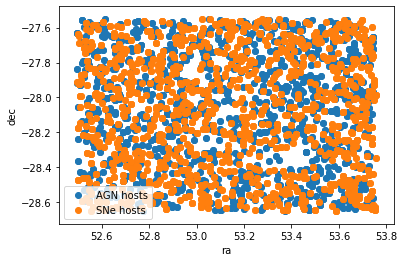

In [74]:
# Check positions
plt.scatter(agn_host_truth['ra_host'], agn_host_truth['dec_host'], label='AGN hosts')
plt.scatter(sne_host_truth['ra_host'], sne_host_truth['dec_host'], label='SNe hosts')
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

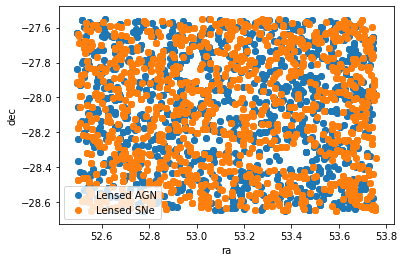

In [75]:
# Check positions
plt.scatter(lensed_agn_truth['ra'], lensed_agn_truth['dec'], label='Lensed AGN')
plt.scatter(lensed_sne_truth['ra'], lensed_sne_truth['dec'], label='Lensed SNe')
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()